#  De belles cartes avec python: mise en pratique



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABvisualisation%20maps%C2%BB&security.allowlist.enabled=false)
<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=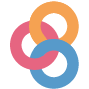)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)

La pratique de la cartographie se fera, dans ce cours, en répliquant des cartes qu'on peut trouver sur
la page de l'*open-data* de la ville de Paris 
[ici](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name).

Produire de belles cartes demande du temps mais aussi du bon sens. En fonction de la structure des données, certaines représentations sont à éviter voire à exclure. L'excellent guide [disponible ici](https://juliedjidji.github.io/memocarto/semio.html) propose quelques règles et évoque les erreurs à éviter lorsqu'on désire effectuer des
représentations spatiales. 


Ce TP vise à initier:

* Au module graphique de [geopandas](https://geopandas.org/mapping.html) ainsi qu'aux packages [geoplot](https://residentmario.github.io/geoplot/index.html) et
[contextily](https://contextily.readthedocs.io/en/latest/intro_guide.html) pour la construction de cartes figées. `geoplot` est construit sur `seaborn` et constitue ainsi une extension des graphiques de base.
* Au package [folium](https://python-visualization.github.io/folium/) qui est un point d'accès vers la librairie JavaScript [leaflet](https://leafletjs.com/) permettant de produire des cartes interactives

Les données utilisées sont :

* Un sous-ensemble des données de [paris open data](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name) a été mis à disposition
sur {{< githubrepo >}} pour faciliter l'import (élimination des colonnes
qui ne nous servirons pas mais ralentissent l'import)
* [La localisation précise des stations](https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr)
* [Arrondissements parisiens](https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr)

Dans la première partie, nous allons utiliser les packages suivants:


In [ ]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import geoplot
import matplotlib.pyplot as plt
import folium

Certaines librairies géographiques dépendent de `rtree` qui est parfois difficile à installer. Pour installer `rtree`, le mieux est d'utiliser `anaconda`.

Installations préalables : 


In [ ]:
# Sur anaconda
conda install rtree --yes

In [ ]:
# Sur colab
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install geoplot

## Première carte avec l'API `matplotlib` de `geopandas`

{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 1: Importer les données**

Importer les données de compteurs de vélos en deux temps.

1. D'abord, les comptages peuvent être trouvés à l'adresse <https://github.com/linogaliana/python-datascientist/raw/master/data/bike.csv>. :warning: Il s'agit de données
compressées au format `gzip`, il faut donc utiliser l'option `compression`. Nommer cet objet `comptages`.


In [ ]:
# 1. Chargement de "comptages"
comptages = pd.read_csv('https://github.com/linogaliana/python-datascientist/raw/master/data/bike.csv', compression = 'gzip')
#comptages.head()

2. Importer les données de localisation des compteurs à partir de l'url <https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `compteurs`.


In [ ]:
#2. Chargement de "compteurs"
compteurs = gpd.read_file("https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
#compteurs.head()

3. On va également utiliser les données d'arrondissements de la ville de Paris. Importer ces données depuis <https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `arrondissements`.



In [ ]:
#3. Chargement de "arrondissements"
arrondissements = gpd.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
# arrondissements.head()

4. Utiliser la méthode `plot` pour représenter les localisations des compteurs dans l'espace. C'est, on peut l'avouer, peu informatif sans apport extérieur. Il va donc falloir travailler un peu l'esthétique


In [ ]:
# 4. Localisation des compteurs
compteurs.plot()

On serait tenté de faire un *merge* de la base compteurs et comptages. En l'occurrence, il s'agirait d'un produit cartésien puisqu'il s'agit de faire exploser la base spatiale. Avec des données spatiales, c'est souvent une très mauvaise idée. Cela duplique les points, créant des difficultés à représenter les données mais aussi ralentit les calculs. Sauf à utiliser la méthode `dissolve` (qui va agréger *k* fois la même géométrie...), les géométries sont perdues lorsqu'on effectue des `groupby`.  



Maintenant, tout est prêt pour une première carte. `matplotlib` fonctionne selon
le principe des couches. On va de la couche la plus lointaine à celle le plus
en surface. L'exception est lorsqu'on ajoute un fond de carte `contextily` via
`ctx.add_basemap`: on met cet appel en dernier. 

{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 2: Première carte**

Représenter une carte des `compteurs` avec le fonds de carte des `arrondissements`

  * Faire attention à avoir des arrondissements dont l'intérieur est transparent (argument à utiliser: `facecolor`).
  * Faire des bordures d'arrondissements noires et affichez les compteurs en rouge.
  * Pour obtenir un graphique plus grand, vous pouvez utiliser l'argument `figsize = (10,10)`.
  * Pour les localisations, les points doivent être rouges en étant plus transparent au centre (argument à utiliser: `alpha`) 



In [ ]:
# Carte des compteurs par arrondissement
ax = arrondissements.plot(edgecolor = 'black', facecolor="none", figsize = (10,10))
compteurs.plot(ax = ax, alpha = 0.3, color = 'red')
ax

```
## <AxesSubplot:>
```

In [ ]:
plt.savefig("map_arr1.png", bbox_inches='tight')

Vous devriez obtenir cette carte:




{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 3 : Ajouter un fonds de carte avec contextily**

Repartir de la carte précédente.

1. Utiliser `ctx.add_basemap` pour ajouter un fonds de carte. Pour ne pas afficher les axes, vous pouvez utiliser `ax.set_axis_off()`.

:warning: *Par défaut, `contextily` désire un système de projection (crs) qui est le Web Mercator (epsg: 3857). Il faut changer la valeur de l'argument `crs`.*

:warning: *Avec les versions anciennes des packages, il faut utiliser `.to_string` sur un objet CRS pour qu'il soit reconnu par `contextily`. Sur des versions récentes, la valeur numérique du code EPSG est suffisante.*


In [ ]:
# 1. Ajout d'un fond de carte sur la précédente carte
ax = arrondissements.to_crs("EPSG:3857").plot(edgecolor = 'black', facecolor="none", figsize = (10,10))
compteurs.to_crs("EPSG:3857").plot(ax = ax, alpha = 0.3, color = 'red')
ctx.add_basemap(ax, source = ctx.providers.Stamen.Watercolor)
ax.set_axis_off()
ax

```
## <AxesSubplot:>
```

In [ ]:
plt.savefig("map_arr2.png", bbox_inches='tight')

```
## findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
## findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
```


```r
knitr::include_graphics("map_arr2.png")
```

2. Trouver un fonds de carte plus esthétique, qui permette de visualiser les grands axes, parmi ceux possibles. Pour tester l'esthétique, vous pouvez utiliser [cet url](http://leaflet-extras.github.io/leaflet-providers/preview/index.html). La documentation de référence sur les tuiles disponibles est [ici](https://contextily.readthedocs.io/en/latest/providers_deepdive.html) 

In [ ]:
# 2. Choix d'un fond de carte plus esthétique (visualisation des grands axes)
ax = arrondissements.to_crs("EPSG:3857").plot(edgecolor = 'black', facecolor="none", figsize = (10,10))
compteurs.to_crs("EPSG:3857").plot(ax = ax, alpha = 0.3, color = 'red')
ctx.add_basemap(ax, source="https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png")
ax.set_axis_off()
ax

Le principe de la *heatmap* est de construire, à partir d'un nuage de point bidimensionnel, une distribution 2D lissée. La méthode repose sur les estimateurs à noyaux qui sont des méthodes de lissage local. 


Pour le moment, la fonction  `geoplot.kdeplot` n'incorpore pas toutes les fonctionalités de `seaborn.kdeplot`. Pour être en mesure de construire une `heatmap` avec des données pondérées (cf. [cette issue dans le dépôt seaborn](https://github.com/mwaskom/seaborn/issues/1364)), il y a une astuce. Il faut simuler *k* points de valeur 1 autour de la localisation observée. La fonction ci-dessous, qui m'a été bien utile, est pratique


In [ ]:
import numpy as np
def expand_points(shapefile,
                  index_var = "grid_id",
                  weight_var = 'prop',
                  radius_sd = 100,
                  crs = 2154):
    """
    Multiply number of points to be able to have a weighted heatmap
    :param shapefile: Shapefile to consider
    :param index_var: Variable name to set index
    :param weight_var: Variable that should be used
    :param radius_sd: Standard deviation for the radius of the jitter
    :param crs: Projection system that should be used. Recommended option
      is Lambert 93 because points will be jitterized using meters
    :return:
      A geopandas point object with as many points by index as weight
    """

    shpcopy = shapefile
    shpcopy = shpcopy.set_index(index_var)
    shpcopy['npoints'] = np.ceil(shpcopy[weight_var])
    shpcopy['geometry'] = shpcopy['geometry'].centroid
    shpcopy['x'] = shpcopy.geometry.x
    shpcopy['y'] = shpcopy.geometry.y
    shpcopy = shpcopy.to_crs(crs)
    shpcopy = shpcopy.loc[np.repeat(shpcopy.index.values, shpcopy.npoints)]
    shpcopy['x'] = shpcopy['x'] + np.random.normal(0, radius_sd, shpcopy.shape[0])
    shpcopy['y'] = shpcopy['y'] + np.random.normal(0, radius_sd, shpcopy.shape[0])

    gdf = gpd.GeoDataFrame(
        shpcopy,
        geometry = gpd.points_from_xy(shpcopy.x, shpcopy.y),
        crs = crs)

    return gdf

{{% box status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 4 : Data cleaning avant de pouvoir faire une heatmap**

1. Calculer le trafic moyen, pour chaque station, entre 7 heures et 10 heures (bornes incluses) et nommer cet objet `df1`. Faire la même chose, en nommant `df2`, pour le trafic entre 17 et 20 heures (bornes incluses)


In [ ]:
#1. Calcul du trafic moyen
comptages['timestamp'] = pd.to_datetime(comptages['Date et heure de comptage'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
comptages['hour'] = comptages['timestamp'].dt.hour

df1 = comptages[comptages.hour.between(7,10)].groupby('Identifiant du compteur').agg({"Comptage horaire": "mean"}).reset_index()
df2 = comptages[comptages.hour.between(7,10)].groupby('Identifiant du compteur').agg({"Comptage horaire": "mean"}).reset_index()
df1 = compteurs.merge(df1, left_on = "id_compteur", right_on = 'Identifiant du compteur')
df2 = compteurs.merge(df2, left_on = "id_compteur", right_on = 'Identifiant du compteur')

2. Nous allons désormais préparer les données de manière à faire une heatmap. Après avoir compris ce que permet de faire la fonction `expand_points` ci-dessus, créer une fonction `explode_data` qui suive les étapes suivantes. 
  + Convertir un DataFrame dans le système de projection Lambert 93 (epsg: 2154)
  + Appliquer `expand_points` aux noms de variable adéquats. Vous pouvez fixer la valeur de `radius_sd` à `100`. 
  + Reconvertir l'output au format WGS84 (epsg: 4326)


In [ ]:
#2. Creation de la fonction explode_data
## La fonction expand_points multiplie le nombre de points de manière à créer une heatmap
def explode_data(data, index_var = "id_compteur", weight_var = 'Comptage horaire', crs = 2154):
  data_exp = expand_points(data.to_crs(crs),
                  index_var = "id_compteur",
                  weight_var = 'Comptage horaire',
                  radius_sd = 100,
                  crs = crs)
  data_exp = data_exp.to_crs(4326)
  return data_exp

3. Appliquer cette fonction à `df1` et `df2`


In [ ]:
#3. Application de explode_data à df1 et df2
df1_exploded = explode_data(df1)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'expand_points' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "<string>", line 2, in explode_data
```

In [ ]:
df2_exploded = explode_data(df2)

#print(len(df1))
#df1[["name","id_compteur"]].head()
#print(len(df1_exploded))
#df1_exploded[["name","npoints","x","y"]].head()

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'expand_points' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "<string>", line 2, in explode_data
```



**Exercice 5 : Heatmap, enfin !**

Représenter, pour ces deux moments de la journée, la `heatmap` du trafic de vélo avec `geoplot.kdeplot`. Pour cela :

- Appliquer la fonction `geoplot.kdeplot` avec comme consignes :
    + d'utiliser les arguments `shade=True` et `shade_lowest=True` pour colorer l'intérieur des courbes de niveaux obtenues ; 
    + d'utiliser une palette de couleur rouge avec une transparence modérée (`alpha = 0.6`)
    + d'utiliser l'argument `clip` pour ne pas déborder hors de Paris (en cas de doute, se référer à l'aide de `geoplot.kdeplot`)
    + L'argument `bw` (pour *bandwidth*) détermine le plus ou moins fort lissage spatial. Vous pouvez partir d'un bandwidth égal à 0.01 et le faire varier pour voir l'effet sur le résultat 
    
- Ne pas oublier d'ajouter les arrondissements. Avec `geoplot`, il faut utiliser `geoplot.polyplot`. 


In [ ]:
# Exercice 5 : heatmap
fig = plt.figure()
ax = geoplot.kdeplot(df1_exploded,
                      figsize=(10, 10),
                      shade=True, shade_lowest=True,
                      alpha = 0.6,
                      clip = arrondissements,
                      cmap="Reds",
                      bw=.35
                    )
# truc bizarre: bandwidth doit etre beaucoup plus fort sur ma machine windows que sur un notebook tournant sur linux
# pour produire résultat équivalent

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'df1_exploded' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
geoplot.polyplot(arrondissements, ax = ax, zorder = 1)

```
## <AxesSubplot:>
```

In [ ]:
plt.savefig("map_arr3.png", bbox_inches='tight')

```r
knitr::include_graphics("map_arr3.png")
```





## Des cartes réactives grâce à `folium`

De plus en plus de données de visualisation reposent sur la cartographie réactive. Que ce soit dans l'exploration des données ou dans la représentation finale de résultats, la cartographie réactive est très appréciable. 

`folium` offre une interface très flexible et très facile à prendre à main. Les cartes sont construites grâce à la librairie JavaScript `Leaflet.js` mais, sauf si on désire aller loin dans la customisation du résultat, il n'est pas nécessaire d'avoir des notions dans le domaine. 

Un objet folium se construit par couche. La première est l'initialisation de la carte. Les couches suivantes sont les éléments à mettre en valeur. L'initialisation de la carte nécessite la définition d'un point central (paramètre `location`) et d'un zoom de départ (`zoom_start`). Plutôt que de fournir manuellement le point central et le zoom on peut :

1. Déterminer le point central en construisant des colonnes longitudes et latitudes et en prenant la moyenne de celles-ci ;
2. Utiliser la méthode `fit_bounds` qui cale la carte sur les coins sud-ouest et nord-est. En supposant que la carte s'appelle `m`, on fera `m.fit_bounds([sw, ne])`

Le bout de code suivant permet de calculer le centre de la carte


In [ ]:
compteurs['lon'] = compteurs.geometry.x
compteurs['lat'] = compteurs.geometry.y
center = compteurs[['lat', 'lon']].mean().values.tolist()
print(center)

```
## [48.85598761616161, 2.3432322626262625]
```

Alors que le code suivant permet de calculer les coins:


In [ ]:
sw = compteurs[['lat', 'lon']].min().values.tolist()
ne = compteurs[['lat', 'lon']].max().values.tolist()
print(sw)

```
## [48.82024, 2.26542]
```

In [ ]:
print(ne)

```
## [48.89696, 2.40969]
```

Si un fond gris s'affiche, c'est qu'il y a un problème de localisation. Cela provient généralement d'un problème de projection ou d'une inversion des longitudes et latitudes. 

Les longitudes représentent les *x* (axe ouest-est) et les latitudes *y* (axe sud-nord). De manière contrintuitive, `folium` attend qu'on lui fournisse les données sous la forme `[latitude, longitude]` donc `[y,x]`


**Exercice 6 : Visualiser la localisation des stations**

1. Calculer le centre `center`de la carte des données `compteurs`. Il s'obtient en agrègeant l'ensemble des géométries, calculant le centroid et récupèrant la valeur sous forme de liste. Avec une logique similaire, calculez les bornes du sud-ouest `sw` et du nord-est `ne` de la carte. 


In [ ]:
#1. Calcul du centre de la carte de "compteurs" et des bornes sw et ne
compteurs['lon'] = compteurs.geometry.x
compteurs['lat'] = compteurs.geometry.y
center = compteurs[['lat', 'lon']].mean().values.tolist()
print(center)

```
## [48.85598761616161, 2.3432322626262625]
```

In [ ]:
sw = compteurs[['lat', 'lon']].min().values.tolist()
print(sw)

```
## [48.82024, 2.26542]
```

In [ ]:
ne = compteurs[['lat', 'lon']].max().values.tolist()
print(ne)

```
## [48.89696, 2.40969]
```

2. Représenter la localisation des stations en utilisant un zoom optimal. 



In [ ]:
# 2. Carte interactive
from pathlib import Path
Path("leaflet").mkdir(parents=True, exist_ok=True)
m = folium.Map(location = center, tiles='Stamen Toner')

# Ajout des markers 1 à 1 sur la carte
for i in range(0,len(compteurs)):
    folium.Marker([compteurs.iloc[i]['lat'], compteurs.iloc[i]['lon']], popup=compteurs.iloc[i]['nom_compteur']).add_to(m)

```
## <folium.map.Marker object at 0x7fb6f48ded90>
## <folium.map.Marker object at 0x7fb6f48de940>
## <folium.map.Marker object at 0x7fb6f48de280>
## <folium.map.Marker object at 0x7fb6f48de3d0>
## <folium.map.Marker object at 0x7fb6f48de5e0>
## <folium.map.Marker object at 0x7fb6f48de700>
## <folium.map.Marker object at 0x7fb6f48de820>
## <folium.map.Marker object at 0x7fb6f48dea30>
## <folium.map.Marker object at 0x7fb6f48deb50>
## <folium.map.Marker object at 0x7fb6f48defa0>
## <folium.map.Marker object at 0x7fb6f48ded00>
## <folium.map.Marker object at 0x7fb6f48debb0>
## <folium.map.Marker object at 0x7fb6f48de490>
## <folium.map.Marker object at 0x7fb6f45ebd90>
## <folium.map.Marker object at 0x7fb6f436bee0>
## <folium.map.Marker object at 0x7fb6f48f2d00>
## <folium.map.Marker object at 0x7fb6f48f2130>
## <folium.map.Marker object at 0x7fb6f4c0d190>
## <folium.map.Marker object at 0x7fb6f4c0d2b0>
## <folium.map.Marker object at 0x7fb6f4c0d3d0>
## <folium.map.Marker object at 0x7fb6f4c0d4f0>
## <folium.map.Marker object at 0x7fb6f4c0d610>
## <folium.map.Marker object at 0x7fb6f4c0d730>
## <folium.map.Marker object at 0x7fb6f4c0d850>
## <folium.map.Marker object at 0x7fb6f4c0d970>
## <folium.map.Marker object at 0x7fb6f4c0da90>
## <folium.map.Marker object at 0x7fb6f4c0dbb0>
## <folium.map.Marker object at 0x7fb6f4c0dcd0>
## <folium.map.Marker object at 0x7fb6f4c0ddf0>
## <folium.map.Marker object at 0x7fb6f4c0df10>
## <folium.map.Marker object at 0x7fb6f4c0d040>
## <folium.map.Marker object at 0x7fb6f4c49190>
## <folium.map.Marker object at 0x7fb6f4c492b0>
## <folium.map.Marker object at 0x7fb6f4c493d0>
## <folium.map.Marker object at 0x7fb6f4c494f0>
## <folium.map.Marker object at 0x7fb6f4c49610>
## <folium.map.Marker object at 0x7fb6f4c49730>
## <folium.map.Marker object at 0x7fb6f4c49850>
## <folium.map.Marker object at 0x7fb6f4c49970>
## <folium.map.Marker object at 0x7fb6f4c49a90>
## <folium.map.Marker object at 0x7fb6f4c49bb0>
## <folium.map.Marker object at 0x7fb6f4c49cd0>
## <folium.map.Marker object at 0x7fb6f4c49df0>
## <folium.map.Marker object at 0x7fb6f4c49f10>
## <folium.map.Marker object at 0x7fb6f4c49040>
## <folium.map.Marker object at 0x7fb6f4c48190>
## <folium.map.Marker object at 0x7fb6f4c482b0>
## <folium.map.Marker object at 0x7fb6f4c483d0>
## <folium.map.Marker object at 0x7fb6f4c484f0>
## <folium.map.Marker object at 0x7fb6f4c48610>
## <folium.map.Marker object at 0x7fb6f4c48730>
## <folium.map.Marker object at 0x7fb6f4c48850>
## <folium.map.Marker object at 0x7fb6f4c48970>
## <folium.map.Marker object at 0x7fb6f4c48a90>
## <folium.map.Marker object at 0x7fb6f4c48bb0>
## <folium.map.Marker object at 0x7fb6f4c48cd0>
## <folium.map.Marker object at 0x7fb6f4c48df0>
## <folium.map.Marker object at 0x7fb6f4c48f10>
## <folium.map.Marker object at 0x7fb6f4c48040>
## <folium.map.Marker object at 0x7fb70d33a190>
## <folium.map.Marker object at 0x7fb70d33a2b0>
## <folium.map.Marker object at 0x7fb70d33a3d0>
## <folium.map.Marker object at 0x7fb70d33a4f0>
## <folium.map.Marker object at 0x7fb70d33a610>
## <folium.map.Marker object at 0x7fb70d33a730>
## <folium.map.Marker object at 0x7fb70d33a850>
## <folium.map.Marker object at 0x7fb70d33a970>
## <folium.map.Marker object at 0x7fb70d33aa90>
## <folium.map.Marker object at 0x7fb70d33abb0>
## <folium.map.Marker object at 0x7fb70d33acd0>
## <folium.map.Marker object at 0x7fb70d33adf0>
## <folium.map.Marker object at 0x7fb70d33af10>
## <folium.map.Marker object at 0x7fb70d33a040>
## <folium.map.Marker object at 0x7fb703d5f190>
## <folium.map.Marker object at 0x7fb703d5f2b0>
## <folium.map.Marker object at 0x7fb703d5f3d0>
## <folium.map.Marker object at 0x7fb703d5f4f0>
## <folium.map.Marker object at 0x7fb703d5f610>
## <folium.map.Marker object at 0x7fb703d5f730>
## <folium.map.Marker object at 0x7fb703d5f850>
## <folium.map.Marker object at 0x7fb703d5f970>
## <folium.map.Marker object at 0x7fb703d5fa90>
## <folium.map.Marker object at 0x7fb703d5fbb0>
## <folium.map.Marker object at 0x7fb703d5fcd0>
## <folium.map.Marker object at 0x7fb703d5fdf0>
## <folium.map.Marker object at 0x7fb703d5ff10>
## <folium.map.Marker object at 0x7fb703d5f040>
## <folium.map.Marker object at 0x7fb703d72190>
## <folium.map.Marker object at 0x7fb703d722b0>
## <folium.map.Marker object at 0x7fb703d723d0>
## <folium.map.Marker object at 0x7fb703d724f0>
## <folium.map.Marker object at 0x7fb703d72610>
## <folium.map.Marker object at 0x7fb703d72730>
## <folium.map.Marker object at 0x7fb703d72850>
## <folium.map.Marker object at 0x7fb703d72970>
## <folium.map.Marker object at 0x7fb703d72a90>
## <folium.map.Marker object at 0x7fb703d72bb0>
## <folium.map.Marker object at 0x7fb703d72cd0>
## <folium.map.Marker object at 0x7fb703d72df0>
```

In [ ]:
m.fit_bounds([sw, ne])
m

```
## <folium.folium.Map object at 0x7fb6f48f2a00>
```

In [ ]:
m.save("leaflet/folium1.html")

La carte obtenue doit ressembler à la suivante:

```r
cat(py$map)
```

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_e299c94d1e9c408e8b06acd14c484553%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_e299c94d1e9c408e8b06acd14c484553%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_e299c94d1e9c408e8b06acd14c484553%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_e299c94d1e9c408e8b06acd14c484553%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B48.85598761616161%2C%202.3432322626262625%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20crs%3A%20L.CRS.EPSG3857%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoom%3A%2010%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoomControl%3A%20true%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20preferCanvas%3A%20false%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20tile_layer_2500c6b7afd44eedafbf0de997de48d1%20%3D%20L.tileLayer%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22https%3A//stamen-tiles-%7Bs%7D.a.ssl.fastly.net/toner/%7Bz%7D/%7Bx%7D/%7By%7D.png%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22attribution%22%3A%20%22Map%20tiles%20by%20%5Cu003ca%20href%3D%5C%22http%3A//stamen.com%5C%22%5Cu003eStamen%20Design%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//creativecommons.org/licenses/by/3.0%5C%22%5Cu003eCC%20BY%203.0%5Cu003c/a%5Cu003e.%20Data%20by%20%5Cu0026copy%3B%20%5Cu003ca%20href%3D%5C%22http%3A//openstreetmap.org%5C%22%5Cu003eOpenStreetMap%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//www.openstreetmap.org/copyright%5C%22%5Cu003eODbL%5Cu003c/a%5Cu003e.%22%2C%20%22detectRetina%22%3A%20false%2C%20%22maxNativeZoom%22%3A%2018%2C%20%22maxZoom%22%3A%2018%2C%20%22minZoom%22%3A%200%2C%20%22noWrap%22%3A%20false%2C%20%22opacity%22%3A%201%2C%20%22subdomains%22%3A%20%22abc%22%2C%20%22tms%22%3A%20false%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e312131f8b6d4fcdb371658f92fff43e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83511%2C%202.33338%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5adae1a08ce34270a8a2b3961a4cf2fe%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f63a278ceea140d887c195a491e1f761%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f63a278ceea140d887c195a491e1f761%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E97%20avenue%20Denfert%20Rochereau%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5adae1a08ce34270a8a2b3961a4cf2fe.setContent%28html_f63a278ceea140d887c195a491e1f761%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e312131f8b6d4fcdb371658f92fff43e.bindPopup%28popup_5adae1a08ce34270a8a2b3961a4cf2fe%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_82409e2a5d2846a4935984110e8d18d7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f7609c6859364c40a080ada6f77c19ca%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6870baff87a742b199aed85e5b01dc3c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6870baff87a742b199aed85e5b01dc3c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20La%20Fayette%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f7609c6859364c40a080ada6f77c19ca.setContent%28html_6870baff87a742b199aed85e5b01dc3c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_82409e2a5d2846a4935984110e8d18d7.bindPopup%28popup_f7609c6859364c40a080ada6f77c19ca%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_60f1e7caf3fa40728f02fa374208010c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83521%2C%202.33307%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bd765d21de9142299f96e7cc619762a7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c6e2ddacb293485eafb9826ac065c99a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c6e2ddacb293485eafb9826ac065c99a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E106%20avenue%20Denfert%20Rochereau%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bd765d21de9142299f96e7cc619762a7.setContent%28html_c6e2ddacb293485eafb9826ac065c99a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_60f1e7caf3fa40728f02fa374208010c.bindPopup%28popup_bd765d21de9142299f96e7cc619762a7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7ef5645a813b424bb2b572b1d2378af6%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87813%2C%202.3497%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_30756b57736f41bcaf2236fc7148ce29%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e3fbd155592c432fb6382b1e85866b33%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e3fbd155592c432fb6382b1e85866b33%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E100%20rue%20La%20Fayette%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_30756b57736f41bcaf2236fc7148ce29.setContent%28html_e3fbd155592c432fb6382b1e85866b33%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7ef5645a813b424bb2b572b1d2378af6.bindPopup%28popup_30756b57736f41bcaf2236fc7148ce29%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8d18620f23124d1292181efe7d9d52d5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.843435%2C%202.383378%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_eeea86d56ceb49b288aa61217f7c2091%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f147ce4af5574f11badb4f8811a8e2dd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f147ce4af5574f11badb4f8811a8e2dd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E135%20avenue%20Daumesnil%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_eeea86d56ceb49b288aa61217f7c2091.setContent%28html_f147ce4af5574f11badb4f8811a8e2dd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8d18620f23124d1292181efe7d9d52d5.bindPopup%28popup_eeea86d56ceb49b288aa61217f7c2091%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8fb262f8f5494f61a9954345816144f7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_203de2e378714cd9b94b7b493f49c29a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1a4534aab9ed4e7aa010bad9948d7f9d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1a4534aab9ed4e7aa010bad9948d7f9d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_203de2e378714cd9b94b7b493f49c29a.setContent%28html_1a4534aab9ed4e7aa010bad9948d7f9d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8fb262f8f5494f61a9954345816144f7.bindPopup%28popup_203de2e378714cd9b94b7b493f49c29a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6300c37125a946a695f1d29785c74220%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cf5f6bc1aca942a8ab05f903d080f6ad%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a900fd4d95f749c889523bd896b074a1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a900fd4d95f749c889523bd896b074a1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cf5f6bc1aca942a8ab05f903d080f6ad.setContent%28html_a900fd4d95f749c889523bd896b074a1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6300c37125a946a695f1d29785c74220.bindPopup%28popup_cf5f6bc1aca942a8ab05f903d080f6ad%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4ffb65ef2fad4dcabfae830ad0a53dee%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_edc33ced14cb4b418f66fd82e50b9ade%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_02ad16bcadde4aae9814ad4c67375b8c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_02ad16bcadde4aae9814ad4c67375b8c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_edc33ced14cb4b418f66fd82e50b9ade.setContent%28html_02ad16bcadde4aae9814ad4c67375b8c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4ffb65ef2fad4dcabfae830ad0a53dee.bindPopup%28popup_edc33ced14cb4b418f66fd82e50b9ade%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_04781e347d344cfdab082f45b312b7d1%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cd8ead0c79d746f6b23233e2670a94aa%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fc374b8755fd4bf4af6fbb4ed634bfbd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fc374b8755fd4bf4af6fbb4ed634bfbd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cd8ead0c79d746f6b23233e2670a94aa.setContent%28html_fc374b8755fd4bf4af6fbb4ed634bfbd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_04781e347d344cfdab082f45b312b7d1.bindPopup%28popup_cd8ead0c79d746f6b23233e2670a94aa%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a4102ed344b749be8b88de3df580f46f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_055d716eec694eab91d73aae630b1024%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_423fe108340746ffb855eaa360ced299%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_423fe108340746ffb855eaa360ced299%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_055d716eec694eab91d73aae630b1024.setContent%28html_423fe108340746ffb855eaa360ced299%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a4102ed344b749be8b88de3df580f46f.bindPopup%28popup_055d716eec694eab91d73aae630b1024%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_61205386014d4f9989f7b0cf17193a0e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_90a65c91f0574f8ab34afd9b7ac2224f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2e850fc0bffe49e7844ac30d92b4dc5d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2e850fc0bffe49e7844ac30d92b4dc5d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_90a65c91f0574f8ab34afd9b7ac2224f.setContent%28html_2e850fc0bffe49e7844ac30d92b4dc5d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_61205386014d4f9989f7b0cf17193a0e.bindPopup%28popup_90a65c91f0574f8ab34afd9b7ac2224f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8cad9118d5464a629769dea3aa46a9f9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846099%2C%202.375456%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_37e80257f22840e1bb6ad165078c30c0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_05d5d6c727f94b088b17927ad63043d0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_05d5d6c727f94b088b17927ad63043d0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20boulevard%20Diderot%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_37e80257f22840e1bb6ad165078c30c0.setContent%28html_05d5d6c727f94b088b17927ad63043d0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8cad9118d5464a629769dea3aa46a9f9.bindPopup%28popup_37e80257f22840e1bb6ad165078c30c0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8cfdbc818ce14f51954a05fc37f3716c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d215f75805ba4672a3eb02f723202be0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0d7289a151294c5aa1afe1ab8dcdbff3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0d7289a151294c5aa1afe1ab8dcdbff3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d215f75805ba4672a3eb02f723202be0.setContent%28html_0d7289a151294c5aa1afe1ab8dcdbff3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8cfdbc818ce14f51954a05fc37f3716c.bindPopup%28popup_d215f75805ba4672a3eb02f723202be0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6f9760c7241742399d6f36179fc32c33%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_415e22be7cc64f629a8156efb44255c7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e24c286839314b04a9706f199f7ed9df%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e24c286839314b04a9706f199f7ed9df%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_415e22be7cc64f629a8156efb44255c7.setContent%28html_e24c286839314b04a9706f199f7ed9df%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6f9760c7241742399d6f36179fc32c33.bindPopup%28popup_415e22be7cc64f629a8156efb44255c7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e2b82ae0f566472281a7c5e8db57b454%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86149%2C%202.37376%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a70d5095c5db4c00b5e2dc96bb10850f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a284d59d864d49bf9354efaaf0e0f6a0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a284d59d864d49bf9354efaaf0e0f6a0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E67%20boulevard%20Voltaire%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a70d5095c5db4c00b5e2dc96bb10850f.setContent%28html_a284d59d864d49bf9354efaaf0e0f6a0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e2b82ae0f566472281a7c5e8db57b454.bindPopup%28popup_a70d5095c5db4c00b5e2dc96bb10850f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f69a2552d7cd42cbadfe0b50b1a8598c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.874716%2C%202.292439%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3bcb5ea4bd5749339477e032fb570d8c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5e223271e32042879dab1191a9b0467f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5e223271e32042879dab1191a9b0467f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3bcb5ea4bd5749339477e032fb570d8c.setContent%28html_5e223271e32042879dab1191a9b0467f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f69a2552d7cd42cbadfe0b50b1a8598c.bindPopup%28popup_3bcb5ea4bd5749339477e032fb570d8c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_12286af5dd8945a2bf7db449c69b7f28%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87451%2C%202.29215%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6dac5d57fa1143a9a096f88b2c9935ad%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_757bbe825ac347bb8ce598bf5af870d4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_757bbe825ac347bb8ce598bf5af870d4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E7%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6dac5d57fa1143a9a096f88b2c9935ad.setContent%28html_757bbe825ac347bb8ce598bf5af870d4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_12286af5dd8945a2bf7db449c69b7f28.bindPopup%28popup_6dac5d57fa1143a9a096f88b2c9935ad%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_fa57252a86ad4fd58e6a7208fae0eec0%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86155%2C%202.37407%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5074905406df40e493f8b15fe9745e36%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_15c3e9a96a974e929709e94f76b1abec%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_15c3e9a96a974e929709e94f76b1abec%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Voltaire%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5074905406df40e493f8b15fe9745e36.setContent%28html_15c3e9a96a974e929709e94f76b1abec%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_fa57252a86ad4fd58e6a7208fae0eec0.bindPopup%28popup_5074905406df40e493f8b15fe9745e36%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_19638a6b852546328e11d453fbee45dd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87756%2C%202.35535%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6025d346a6444dea90d9bcd32e4cdc7d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7e7f66b8082f460f99f2a3debd0b810e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7e7f66b8082f460f99f2a3debd0b810e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E89%20boulevard%20de%20Magenta%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6025d346a6444dea90d9bcd32e4cdc7d.setContent%28html_7e7f66b8082f460f99f2a3debd0b810e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_19638a6b852546328e11d453fbee45dd.bindPopup%28popup_6025d346a6444dea90d9bcd32e4cdc7d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_25e47fd1460e49ed9effaa6064975628%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88181%2C%202.281546%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3012211f879a4080ad0827abb575b7a3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_af9695dd221c4bb092a4f07302fd93a3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_af9695dd221c4bb092a4f07302fd93a3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E16%20avenue%20de%20la%20Porte%20des%20Ternes%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3012211f879a4080ad0827abb575b7a3.setContent%28html_af9695dd221c4bb092a4f07302fd93a3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_25e47fd1460e49ed9effaa6064975628.bindPopup%28popup_3012211f879a4080ad0827abb575b7a3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ddd4b94c3dbc4e37b692a69779b5cfd3%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84015%2C%202.26733%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_419b95ca54da4abab211345d623fcf51%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e708a4c979304502bd35c4120170f3c9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e708a4c979304502bd35c4120170f3c9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_419b95ca54da4abab211345d623fcf51.setContent%28html_e708a4c979304502bd35c4120170f3c9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ddd4b94c3dbc4e37b692a69779b5cfd3.bindPopup%28popup_419b95ca54da4abab211345d623fcf51%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_809efd0b13584bc4b1e3af80ddc46d80%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.877726%2C%202.354926%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_898fac8058a5454f8dda54566ae052ce%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d68472c1ecb3416aae31aff3225f244c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d68472c1ecb3416aae31aff3225f244c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E102%20boulevard%20de%20Magenta%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_898fac8058a5454f8dda54566ae052ce.setContent%28html_d68472c1ecb3416aae31aff3225f244c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_809efd0b13584bc4b1e3af80ddc46d80.bindPopup%28popup_898fac8058a5454f8dda54566ae052ce%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6c52224567de491bbb8d73a6567ded2b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86057%2C%202.38886%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a3c829a4ec8a472fb815635bbccf97cf%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a30f9f462a8d4af2a6aa54530862b242%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a30f9f462a8d4af2a6aa54530862b242%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E26%20boulevard%20de%20M%C3%A9nilmontant%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a3c829a4ec8a472fb815635bbccf97cf.setContent%28html_a30f9f462a8d4af2a6aa54530862b242%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6c52224567de491bbb8d73a6567ded2b.bindPopup%28popup_a3c829a4ec8a472fb815635bbccf97cf%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_837f0bde93454af6848c82df2f8482e9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.881626%2C%202.281203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_83002430d30e4cddb11c04006d50b250%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_39bf6c95a09d4c31a2afc6aa34fcf5a0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_39bf6c95a09d4c31a2afc6aa34fcf5a0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2016%20avenue%20de%20la%20%20Porte%20des%20Ternes%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_83002430d30e4cddb11c04006d50b250.setContent%28html_39bf6c95a09d4c31a2afc6aa34fcf5a0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_837f0bde93454af6848c82df2f8482e9.bindPopup%28popup_83002430d30e4cddb11c04006d50b250%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a996f3e7c56d4133936f2fbe47b02aca%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830449%2C%202.353199%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b3935f5dd64e47eeb5b5fb8eb188e5da%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7c7b105904474a5c85ca88a3d3c1527b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7c7b105904474a5c85ca88a3d3c1527b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Auguste%20Blanqui%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b3935f5dd64e47eeb5b5fb8eb188e5da.setContent%28html_7c7b105904474a5c85ca88a3d3c1527b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a996f3e7c56d4133936f2fbe47b02aca.bindPopup%28popup_b3935f5dd64e47eeb5b5fb8eb188e5da%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_74c2fbff5a9a4ca3aecc01bfb3a7ad46%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86077%2C%202.37305%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_29e22f6a4f0e4ef1bfcb033f09e8295d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2bb976e623ee47f4a1f442468783bed1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2bb976e623ee47f4a1f442468783bed1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Richard%20Lenoir%20%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_29e22f6a4f0e4ef1bfcb033f09e8295d.setContent%28html_2bb976e623ee47f4a1f442468783bed1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_74c2fbff5a9a4ca3aecc01bfb3a7ad46.bindPopup%28popup_29e22f6a4f0e4ef1bfcb033f09e8295d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c4b8f11523d74fcf86a0b5aaf806a7ee%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82658%2C%202.38409%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4c9753fd38044fbd955d0ac89dfa8664%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0bd354a654c24840a976ceba57b0b0a4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0bd354a654c24840a976ceba57b0b0a4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4c9753fd38044fbd955d0ac89dfa8664.setContent%28html_0bd354a654c24840a976ceba57b0b0a4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c4b8f11523d74fcf86a0b5aaf806a7ee.bindPopup%28popup_4c9753fd38044fbd955d0ac89dfa8664%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_eddd9d80439b4106b2e7d762efbffb8e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3a49b9bbfa90476fb4534039829f5e00%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_973df32c7394452b848e08a00514bfde%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_973df32c7394452b848e08a00514bfde%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3a49b9bbfa90476fb4534039829f5e00.setContent%28html_973df32c7394452b848e08a00514bfde%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_eddd9d80439b4106b2e7d762efbffb8e.bindPopup%28popup_3a49b9bbfa90476fb4534039829f5e00%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_af5a5a97103a4a018cccdb9bfbbe5a6d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b55e840119484369bcc3563304afbf73%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_37da3b1de6544f279eae90cdb1b51b1b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_37da3b1de6544f279eae90cdb1b51b1b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b55e840119484369bcc3563304afbf73.setContent%28html_37da3b1de6544f279eae90cdb1b51b1b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_af5a5a97103a4a018cccdb9bfbbe5a6d.bindPopup%28popup_b55e840119484369bcc3563304afbf73%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_3f18f5c65fa241308dfa5b87ba9c858f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860852%2C%202.372279%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_889bb4f01b9a41c2860107cd10cc129e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_df428827c6374d85a3f9a9e3a8829526%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_df428827c6374d85a3f9a9e3a8829526%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E77%20boulevard%20Richard%20Lenoir%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_889bb4f01b9a41c2860107cd10cc129e.setContent%28html_df428827c6374d85a3f9a9e3a8829526%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_3f18f5c65fa241308dfa5b87ba9c858f.bindPopup%28popup_889bb4f01b9a41c2860107cd10cc129e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e2946189fdc24815a4449bb8e0d3c8a4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_206d9d43b13444c2826b175fb37259dd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6383a3231bce4f9fa8f9bf428fe6e349%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6383a3231bce4f9fa8f9bf428fe6e349%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_206d9d43b13444c2826b175fb37259dd.setContent%28html_6383a3231bce4f9fa8f9bf428fe6e349%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e2946189fdc24815a4449bb8e0d3c8a4.bindPopup%28popup_206d9d43b13444c2826b175fb37259dd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0d7766332706445090fd269fd6b1976f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_048c6fea3a5244308515eedc798b35b1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8beecbf78452438e823f77f6f857d9f0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8beecbf78452438e823f77f6f857d9f0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_048c6fea3a5244308515eedc798b35b1.setContent%28html_8beecbf78452438e823f77f6f857d9f0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0d7766332706445090fd269fd6b1976f.bindPopup%28popup_048c6fea3a5244308515eedc798b35b1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_577702db2d6848f889dbefb7b29aad77%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_21f0ddb72a1847db84c54b5652e9440f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_480f85aac77544899200417e69341233%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_480f85aac77544899200417e69341233%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_21f0ddb72a1847db84c54b5652e9440f.setContent%28html_480f85aac77544899200417e69341233%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_577702db2d6848f889dbefb7b29aad77.bindPopup%28popup_21f0ddb72a1847db84c54b5652e9440f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6a591fb7ae5f42a2bb0318d17ad0b747%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4fd2efdd29f148478e48fbb8d9b35f16%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d2c966acd7714e7891f38ea5536c52ba%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d2c966acd7714e7891f38ea5536c52ba%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4fd2efdd29f148478e48fbb8d9b35f16.setContent%28html_d2c966acd7714e7891f38ea5536c52ba%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6a591fb7ae5f42a2bb0318d17ad0b747.bindPopup%28popup_4fd2efdd29f148478e48fbb8d9b35f16%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_cb3293fa865e4fffaf40e09df23cf925%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8d99aca513aa4dfea79f1b44a876f341%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8fe3b11d73924cff8ea0a9e43525cf66%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8fe3b11d73924cff8ea0a9e43525cf66%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8d99aca513aa4dfea79f1b44a876f341.setContent%28html_8fe3b11d73924cff8ea0a9e43525cf66%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_cb3293fa865e4fffaf40e09df23cf925.bindPopup%28popup_8d99aca513aa4dfea79f1b44a876f341%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_68ce2d70b41f477899a851ed2e7cedc9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_28eb0cab404d4fc9810e6a3d7ab94a5f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9ad0f06566cf42fb8532ae41aea950ac%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9ad0f06566cf42fb8532ae41aea950ac%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_28eb0cab404d4fc9810e6a3d7ab94a5f.setContent%28html_9ad0f06566cf42fb8532ae41aea950ac%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_68ce2d70b41f477899a851ed2e7cedc9.bindPopup%28popup_28eb0cab404d4fc9810e6a3d7ab94a5f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_36616817e9984865bb71156e568785ec%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_775772ff0dab476a897a80602f63610e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8f132196a7e84643b3f80cce32b7ce1d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8f132196a7e84643b3f80cce32b7ce1d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_775772ff0dab476a897a80602f63610e.setContent%28html_8f132196a7e84643b3f80cce32b7ce1d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_36616817e9984865bb71156e568785ec.bindPopup%28popup_775772ff0dab476a897a80602f63610e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_79974c93b58345c8ac8c1616278ab000%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_27a0ab436f69412aa251b2dd4d7d0dd7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_df0b3645204b493d8ee97c53588d850a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_df0b3645204b493d8ee97c53588d850a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_27a0ab436f69412aa251b2dd4d7d0dd7.setContent%28html_df0b3645204b493d8ee97c53588d850a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_79974c93b58345c8ac8c1616278ab000.bindPopup%28popup_27a0ab436f69412aa251b2dd4d7d0dd7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d65addeecbed409cbd3da23eda324ac9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82682%2C%202.38465%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_39763b177e714296b0616823e8b14142%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_796efad84d6a4270b365a80e463fef34%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_796efad84d6a4270b365a80e463fef34%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_39763b177e714296b0616823e8b14142.setContent%28html_796efad84d6a4270b365a80e463fef34%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d65addeecbed409cbd3da23eda324ac9.bindPopup%28popup_39763b177e714296b0616823e8b14142%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7c6c95ca6af4424dbcaa7aba371c98c8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83992%2C%202.26694%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f4ae63b87bef48d5b02878228100a799%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ffee6d08ea2240489395fd3e96fefc83%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ffee6d08ea2240489395fd3e96fefc83%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f4ae63b87bef48d5b02878228100a799.setContent%28html_ffee6d08ea2240489395fd3e96fefc83%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7c6c95ca6af4424dbcaa7aba371c98c8.bindPopup%28popup_f4ae63b87bef48d5b02878228100a799%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ef29a9f1f1da43e7b62d5157c1f5e81e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.840801%2C%202.333233%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d0fee1c682d04293bcb5d1c5f36baf69%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1df3e2166c2e4dee9a517aa131640265%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1df3e2166c2e4dee9a517aa131640265%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E152%20boulevard%20du%20Montparnasse%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d0fee1c682d04293bcb5d1c5f36baf69.setContent%28html_1df3e2166c2e4dee9a517aa131640265%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ef29a9f1f1da43e7b62d5157c1f5e81e.bindPopup%28popup_d0fee1c682d04293bcb5d1c5f36baf69%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f0e6c4afa72b43298a521bf2742f2cb4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.840801%2C%202.333233%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_646dea6522894e24b3cc921a506507cb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5a9d41e03c7e48a79b3426ed0a25e0d0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5a9d41e03c7e48a79b3426ed0a25e0d0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E152%20boulevard%20du%20Montparnasse%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_646dea6522894e24b3cc921a506507cb.setContent%28html_5a9d41e03c7e48a79b3426ed0a25e0d0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f0e6c4afa72b43298a521bf2742f2cb4.bindPopup%28popup_646dea6522894e24b3cc921a506507cb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d3abb93001864fa08280270acc93095a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83068%2C%202.35348%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b3f5e15911d14b40be8cedafbf666557%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b931dd2498ad4578b2a25fae20e4934f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b931dd2498ad4578b2a25fae20e4934f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20boulevard%20Auguste%20Blanqui%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b3f5e15911d14b40be8cedafbf666557.setContent%28html_b931dd2498ad4578b2a25fae20e4934f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d3abb93001864fa08280270acc93095a.bindPopup%28popup_b3f5e15911d14b40be8cedafbf666557%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0da1ae35f0c14e84bd053e9b4faba618%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86179%2C%202.32014%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a940dc558a594716b8c9a54a78432ccb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0dddc4f860034fd19b9d99d6526844ba%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0dddc4f860034fd19b9d99d6526844ba%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E243%20boulevard%20Saint%20Germain%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a940dc558a594716b8c9a54a78432ccb.setContent%28html_0dddc4f860034fd19b9d99d6526844ba%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0da1ae35f0c14e84bd053e9b4faba618.bindPopup%28popup_a940dc558a594716b8c9a54a78432ccb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_579e645343e944bba7e98019df535bab%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_086674fa1710478e86787376c92dde0f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e2d83c51e41745529f1ada1535c24ed5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e2d83c51e41745529f1ada1535c24ed5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_086674fa1710478e86787376c92dde0f.setContent%28html_e2d83c51e41745529f1ada1535c24ed5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_579e645343e944bba7e98019df535bab.bindPopup%28popup_086674fa1710478e86787376c92dde0f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_898dbff21b884a779f77636c92eac7f4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c31da07387cb4e7ca2d606dbd752c4ef%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8b8e3a068e82432c9f4feb386e7b40dc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8b8e3a068e82432c9f4feb386e7b40dc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c31da07387cb4e7ca2d606dbd752c4ef.setContent%28html_8b8e3a068e82432c9f4feb386e7b40dc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_898dbff21b884a779f77636c92eac7f4.bindPopup%28popup_c31da07387cb4e7ca2d606dbd752c4ef%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_728353e665374ff088f2545f45de12c4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88926%2C%202.37472%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3157ceb035634f8284a13efe7c0873c9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_922e1e24ddb54a5f82b9bf5cbd4e1455%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_922e1e24ddb54a5f82b9bf5cbd4e1455%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E87%20avenue%20de%20Flandre%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3157ceb035634f8284a13efe7c0873c9.setContent%28html_922e1e24ddb54a5f82b9bf5cbd4e1455%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_728353e665374ff088f2545f45de12c4.bindPopup%28popup_3157ceb035634f8284a13efe7c0873c9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6b18d3105f3b441aba078da1e8ab6eff%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.889046%2C%202.374872%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1b6f8ca4dbf343eb935adec80ac1971e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a87ad75f88054c109bca4763fa005bb6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a87ad75f88054c109bca4763fa005bb6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20avenue%20de%20Flandre%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1b6f8ca4dbf343eb935adec80ac1971e.setContent%28html_a87ad75f88054c109bca4763fa005bb6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6b18d3105f3b441aba078da1e8ab6eff.bindPopup%28popup_1b6f8ca4dbf343eb935adec80ac1971e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f181f88f15be4a4da4c877c88ff5016a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86357%2C%202.32203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bf151df6a46d46d09c757b3c89f829c8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_170cb0c93e0e4dea8b54a84cfcf0c677%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_170cb0c93e0e4dea8b54a84cfcf0c677%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20des%20Tuileries%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bf151df6a46d46d09c757b3c89f829c8.setContent%28html_170cb0c93e0e4dea8b54a84cfcf0c677%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f181f88f15be4a4da4c877c88ff5016a.bindPopup%28popup_bf151df6a46d46d09c757b3c89f829c8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a53d603c54f04c5f86c79251a78e24c1%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86357%2C%202.32203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_025d5037c7d0400ea4e5b2247c9808db%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_017f83201cb0455a8ddcacd33be78650%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_017f83201cb0455a8ddcacd33be78650%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20des%20Tuileries%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_025d5037c7d0400ea4e5b2247c9808db.setContent%28html_017f83201cb0455a8ddcacd33be78650%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a53d603c54f04c5f86c79251a78e24c1.bindPopup%28popup_025d5037c7d0400ea4e5b2247c9808db%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_dce94b9c438e4e24aa05f7787e99fa55%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86451%2C%202.40932%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e3c6107d840844fdbd2a765bf96cbf1a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_32b21aed657e4a92940eacbc8fb839cd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_32b21aed657e4a92940eacbc8fb839cd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E2%20avenue%20de%20la%20Porte%20de%20Bagnolet%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e3c6107d840844fdbd2a765bf96cbf1a.setContent%28html_32b21aed657e4a92940eacbc8fb839cd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_dce94b9c438e4e24aa05f7787e99fa55.bindPopup%28popup_e3c6107d840844fdbd2a765bf96cbf1a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d625b0e3bfa24e1ab3363fb1b4a40d9b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869873%2C%202.307419%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a60a6a7636b44ebaa974b1826ba2a8ff%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_579cb12fe20c4b9282235c4119b2e739%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_579cb12fe20c4b9282235c4119b2e739%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E44%20avenue%20des%20Champs%20Elys%C3%A9es%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a60a6a7636b44ebaa974b1826ba2a8ff.setContent%28html_579cb12fe20c4b9282235c4119b2e739%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d625b0e3bfa24e1ab3363fb1b4a40d9b.bindPopup%28popup_a60a6a7636b44ebaa974b1826ba2a8ff%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a0ac831604234a289f78e4817222ab50%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82024%2C%202.35902%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_56855ff3754c412fa21711f316d7ab06%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_88740ecaef014cebab63a4f7fa4b82aa%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_88740ecaef014cebab63a4f7fa4b82aa%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E180%20avenue%20d%27Italie%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_56855ff3754c412fa21711f316d7ab06.setContent%28html_88740ecaef014cebab63a4f7fa4b82aa%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a0ac831604234a289f78e4817222ab50.bindPopup%28popup_56855ff3754c412fa21711f316d7ab06%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_be600a9248514016bbd04407f2d11f35%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.842091%2C%202.301%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_858fc7153032470c8f345311d488f4f6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_428055caa6e1475081302671b9fc90c6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_428055caa6e1475081302671b9fc90c6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E129%20rue%20Lecourbe%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_858fc7153032470c8f345311d488f4f6.setContent%28html_428055caa6e1475081302671b9fc90c6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_be600a9248514016bbd04407f2d11f35.bindPopup%28popup_858fc7153032470c8f345311d488f4f6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_627c1628616040de802a8582c64f0421%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82026%2C%202.3592%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1e743246e74444c3828ee95150c21251%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0754e5b4044a4efa8305d5ad6ea99001%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0754e5b4044a4efa8305d5ad6ea99001%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E147%20avenue%20d%27Italie%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1e743246e74444c3828ee95150c21251.setContent%28html_0754e5b4044a4efa8305d5ad6ea99001%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_627c1628616040de802a8582c64f0421.bindPopup%28popup_1e743246e74444c3828ee95150c21251%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_2ada3e33a3784938bc15b9f95cc08b17%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869831%2C%202.307076%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9274a9879c2143d39190105e2b675a87%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b107a86e7c894c16a76e3d1d1a8bb73e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b107a86e7c894c16a76e3d1d1a8bb73e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E33%20avenue%20des%20Champs%20Elys%C3%A9es%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9274a9879c2143d39190105e2b675a87.setContent%28html_b107a86e7c894c16a76e3d1d1a8bb73e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_2ada3e33a3784938bc15b9f95cc08b17.bindPopup%28popup_9274a9879c2143d39190105e2b675a87%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_55376b048a314adeb9d8401bb5bacf85%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84216%2C%202.30115%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4483da7ea52e471a81bb4445659cb20a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6e7f927cbde34417840e4e986ce61af0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6e7f927cbde34417840e4e986ce61af0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E132%20rue%20Lecourbe%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4483da7ea52e471a81bb4445659cb20a.setContent%28html_6e7f927cbde34417840e4e986ce61af0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_55376b048a314adeb9d8401bb5bacf85.bindPopup%28popup_4483da7ea52e471a81bb4445659cb20a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7de6e6b04dbf46adb0577704c2c3e53a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86373%2C%202.31973%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_53de1ed3245b449895678d05a8bde291%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_814cafdd63ee40009e847e7b994ef776%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_814cafdd63ee40009e847e7b994ef776%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_53de1ed3245b449895678d05a8bde291.setContent%28html_814cafdd63ee40009e847e7b994ef776%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7de6e6b04dbf46adb0577704c2c3e53a.bindPopup%28popup_53de1ed3245b449895678d05a8bde291%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a891063fc9264e6a88b6b3ed2320182c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86282%2C%202.31061%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c1ddb242dfc14f9ab7bee8b64e1f22da%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ad3693c4634243c7b78658717a3b49c7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ad3693c4634243c7b78658717a3b49c7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c1ddb242dfc14f9ab7bee8b64e1f22da.setContent%28html_ad3693c4634243c7b78658717a3b49c7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a891063fc9264e6a88b6b3ed2320182c.bindPopup%28popup_c1ddb242dfc14f9ab7bee8b64e1f22da%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_40def813a21f478698b7724f7fb9ece3%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86378%2C%202.32003%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_103eb83603f84d36b494eb72b97ff9fa%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d4f61ede076d4156a2891049800e9324%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d4f61ede076d4156a2891049800e9324%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_103eb83603f84d36b494eb72b97ff9fa.setContent%28html_d4f61ede076d4156a2891049800e9324%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_40def813a21f478698b7724f7fb9ece3.bindPopup%28popup_103eb83603f84d36b494eb72b97ff9fa%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_dda11067828446e0948bef70da973504%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86284%2C%202.310345%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0ad404de30e44e398e656e37a6b6046c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_30eef141f6bf4df3953c67ce8a8ec5d8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_30eef141f6bf4df3953c67ce8a8ec5d8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0ad404de30e44e398e656e37a6b6046c.setContent%28html_30eef141f6bf4df3953c67ce8a8ec5d8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_dda11067828446e0948bef70da973504.bindPopup%28popup_0ad404de30e44e398e656e37a6b6046c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_11d22dafd63646438550c244b1d0f426%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82108%2C%202.32537%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_62fe4eeff5d145f0973263041617375b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1e7eb9439e114261a91546fe79e97b8c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1e7eb9439e114261a91546fe79e97b8c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E3%20avenue%20de%20la%20Porte%20D%27Orl%C3%A9ans%20%28gare%20routi%C3%A8re%29%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_62fe4eeff5d145f0973263041617375b.setContent%28html_1e7eb9439e114261a91546fe79e97b8c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_11d22dafd63646438550c244b1d0f426.bindPopup%28popup_62fe4eeff5d145f0973263041617375b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_20322a0537834429a408ee4a1f2cfc79%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d60634eaee274e77baa0b694280e3c61%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_189c8ad81e834138883cb62fcff949b7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_189c8ad81e834138883cb62fcff949b7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d60634eaee274e77baa0b694280e3c61.setContent%28html_189c8ad81e834138883cb62fcff949b7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_20322a0537834429a408ee4a1f2cfc79.bindPopup%28popup_d60634eaee274e77baa0b694280e3c61%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_813e8c7852614fbf88312f3cb15a16b2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7f9ddf9911794ee7bbcdab6f5ae2c781%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3edae1e7048144fc892a315393bb8ce3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3edae1e7048144fc892a315393bb8ce3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7f9ddf9911794ee7bbcdab6f5ae2c781.setContent%28html_3edae1e7048144fc892a315393bb8ce3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_813e8c7852614fbf88312f3cb15a16b2.bindPopup%28popup_7f9ddf9911794ee7bbcdab6f5ae2c781%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e0d6cb5a578f4bd0a971055d0d91e9ef%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cfbde6ef94f84bb5924af0c6cca82c11%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_662ab16b52224698bbf32e1c982e0146%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_662ab16b52224698bbf32e1c982e0146%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cfbde6ef94f84bb5924af0c6cca82c11.setContent%28html_662ab16b52224698bbf32e1c982e0146%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e0d6cb5a578f4bd0a971055d0d91e9ef.bindPopup%28popup_cfbde6ef94f84bb5924af0c6cca82c11%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_37d33ecbf19b41f684f55d41803fb58d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cbfdb6fff4d940c6af23dcedf7b9aa9d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fa2c5bbbfff84b38b319d176001290ed%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fa2c5bbbfff84b38b319d176001290ed%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cbfdb6fff4d940c6af23dcedf7b9aa9d.setContent%28html_fa2c5bbbfff84b38b319d176001290ed%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_37d33ecbf19b41f684f55d41803fb58d.bindPopup%28popup_cbfdb6fff4d940c6af23dcedf7b9aa9d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_210111bd8b3b4eb2b243262d0f656026%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b5fc9ea160ad4d13995f05c3d259ed13%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_228841e3db1740b79be83154c88b814e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_228841e3db1740b79be83154c88b814e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b5fc9ea160ad4d13995f05c3d259ed13.setContent%28html_228841e3db1740b79be83154c88b814e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_210111bd8b3b4eb2b243262d0f656026.bindPopup%28popup_b5fc9ea160ad4d13995f05c3d259ed13%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_05de3fbe392d4724a34e5b1eca44de36%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3fac1645856241388b84e6d03c138a91%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f7f4fe5be25647abb641254b00a809a2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f7f4fe5be25647abb641254b00a809a2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3fac1645856241388b84e6d03c138a91.setContent%28html_f7f4fe5be25647abb641254b00a809a2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_05de3fbe392d4724a34e5b1eca44de36.bindPopup%28popup_3fac1645856241388b84e6d03c138a91%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1d385fcb78bc4e07b53f920912b5aa5f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d90e143dbfc341fca79eea79f9fe3fa8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d855488680b54a1da7e9beb819845769%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d855488680b54a1da7e9beb819845769%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d90e143dbfc341fca79eea79f9fe3fa8.setContent%28html_d855488680b54a1da7e9beb819845769%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1d385fcb78bc4e07b53f920912b5aa5f.bindPopup%28popup_d90e143dbfc341fca79eea79f9fe3fa8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d162607d07634f15a32a9ede882ad351%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cc744d41312644058cc1ba0a3776cf6e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7f61495455eb4efca439a2bf2241ed08%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7f61495455eb4efca439a2bf2241ed08%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cc744d41312644058cc1ba0a3776cf6e.setContent%28html_7f61495455eb4efca439a2bf2241ed08%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d162607d07634f15a32a9ede882ad351.bindPopup%28popup_cc744d41312644058cc1ba0a3776cf6e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b8353f451f2b4f32869bb22c605ef5a7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8d95fedb749f4d629822b26317c1c012%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_04f921ae07d644a9bfbebbdcabd9f875%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_04f921ae07d644a9bfbebbdcabd9f875%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8d95fedb749f4d629822b26317c1c012.setContent%28html_04f921ae07d644a9bfbebbdcabd9f875%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b8353f451f2b4f32869bb22c605ef5a7.bindPopup%28popup_8d95fedb749f4d629822b26317c1c012%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ca4e92fb84964311aa502adc03dcdb15%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_50d180aadfce418e8eef1a456c918f87%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ad40128592d2449892f0dfb98dee9f8e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ad40128592d2449892f0dfb98dee9f8e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_50d180aadfce418e8eef1a456c918f87.setContent%28html_ad40128592d2449892f0dfb98dee9f8e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ca4e92fb84964311aa502adc03dcdb15.bindPopup%28popup_50d180aadfce418e8eef1a456c918f87%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f101096a69d64d01b2e7c49380d333d4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c16b02b13fa34e5bbe1be07426f14adc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0aa8520d34544dee86e80f18231c014a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0aa8520d34544dee86e80f18231c014a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c16b02b13fa34e5bbe1be07426f14adc.setContent%28html_0aa8520d34544dee86e80f18231c014a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f101096a69d64d01b2e7c49380d333d4.bindPopup%28popup_c16b02b13fa34e5bbe1be07426f14adc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_42f67598561c4d97b242032970279cb5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_649c315afdc644f3abb613385f365403%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e28ab43a0220419a92964ae2993e9b4e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e28ab43a0220419a92964ae2993e9b4e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_649c315afdc644f3abb613385f365403.setContent%28html_e28ab43a0220419a92964ae2993e9b4e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_42f67598561c4d97b242032970279cb5.bindPopup%28popup_649c315afdc644f3abb613385f365403%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4c701e23db0b462cba11c3f4dd9e95ac%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2ebe23eccb844376883789fb6f8a60d5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b27796a95a524c709a969b85ad1f9f7d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b27796a95a524c709a969b85ad1f9f7d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2ebe23eccb844376883789fb6f8a60d5.setContent%28html_b27796a95a524c709a969b85ad1f9f7d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4c701e23db0b462cba11c3f4dd9e95ac.bindPopup%28popup_2ebe23eccb844376883789fb6f8a60d5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d870b3f560d447439669fdbb423b0c35%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c7cd4b564dfa42a199a4ce223761359a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a04763f093834994967aa9032234753d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a04763f093834994967aa9032234753d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c7cd4b564dfa42a199a4ce223761359a.setContent%28html_a04763f093834994967aa9032234753d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d870b3f560d447439669fdbb423b0c35.bindPopup%28popup_c7cd4b564dfa42a199a4ce223761359a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a5ab7c8ee3af424abd42ab094014cfca%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a9c055a333b144b581c156e5ec05df04%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_426f9a9ee648413da06fa83f40ea6a06%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_426f9a9ee648413da06fa83f40ea6a06%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a9c055a333b144b581c156e5ec05df04.setContent%28html_426f9a9ee648413da06fa83f40ea6a06%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a5ab7c8ee3af424abd42ab094014cfca.bindPopup%28popup_a9c055a333b144b581c156e5ec05df04%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ef4774b729d14222a978823cac556323%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_413e1470adca4720ad837572ec308a5f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3ef0df1d5f284843bd6a6e28e26aad8e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3ef0df1d5f284843bd6a6e28e26aad8e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_413e1470adca4720ad837572ec308a5f.setContent%28html_3ef0df1d5f284843bd6a6e28e26aad8e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ef4774b729d14222a978823cac556323.bindPopup%28popup_413e1470adca4720ad837572ec308a5f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_78b8132ab54b495c8d9b1fcc528854ba%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_911c122e9c764632846caa37adb0c8e7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a0d8449c4ef841a2867d4a38e35a2302%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a0d8449c4ef841a2867d4a38e35a2302%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_911c122e9c764632846caa37adb0c8e7.setContent%28html_a0d8449c4ef841a2867d4a38e35a2302%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_78b8132ab54b495c8d9b1fcc528854ba.bindPopup%28popup_911c122e9c764632846caa37adb0c8e7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_330222bc091347b3b5e85a611395c357%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bcfff88410834c06b0c205c70ab202bd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bf6be5aadcfb46bca6bb2551a70ebef7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bf6be5aadcfb46bca6bb2551a70ebef7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bcfff88410834c06b0c205c70ab202bd.setContent%28html_bf6be5aadcfb46bca6bb2551a70ebef7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_330222bc091347b3b5e85a611395c357.bindPopup%28popup_bcfff88410834c06b0c205c70ab202bd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c906e9ea98f443cbbc45a4c1c0486488%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_75b0cde3c6104b92a7c9c1ae8307048a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fb9865723fe443fc968cb093bc947db6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fb9865723fe443fc968cb093bc947db6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_75b0cde3c6104b92a7c9c1ae8307048a.setContent%28html_fb9865723fe443fc968cb093bc947db6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c906e9ea98f443cbbc45a4c1c0486488.bindPopup%28popup_75b0cde3c6104b92a7c9c1ae8307048a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e6f7f1f2a90a48d69a504bafdd58d5da%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_feae51f1bfa949828d4e0b4761dc131c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8672073d7e3d404398c02bf70ab1db1b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8672073d7e3d404398c02bf70ab1db1b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_feae51f1bfa949828d4e0b4761dc131c.setContent%28html_8672073d7e3d404398c02bf70ab1db1b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e6f7f1f2a90a48d69a504bafdd58d5da.bindPopup%28popup_feae51f1bfa949828d4e0b4761dc131c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ee140e511c4e4e52b76c61d19d0ea1ab%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d9f7cc01506345cd816c504d5e27215b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1ec9b7429f7e4ff2a9d833da389b2e3b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1ec9b7429f7e4ff2a9d833da389b2e3b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d9f7cc01506345cd816c504d5e27215b.setContent%28html_1ec9b7429f7e4ff2a9d833da389b2e3b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ee140e511c4e4e52b76c61d19d0ea1ab.bindPopup%28popup_d9f7cc01506345cd816c504d5e27215b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_23957d82ea024593843c07df89458c97%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_60f74eb45cef47e7b9df25ee74a78c16%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_153995891d5d4eda8e13e54455aae83f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_153995891d5d4eda8e13e54455aae83f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_60f74eb45cef47e7b9df25ee74a78c16.setContent%28html_153995891d5d4eda8e13e54455aae83f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_23957d82ea024593843c07df89458c97.bindPopup%28popup_60f74eb45cef47e7b9df25ee74a78c16%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_956fa3b961a0475899470eb9586dc7c4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_af3a8bb9335b4856845be16fd52634b7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4f8a46bbbe494ca4a736b6c7ca1f2d94%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4f8a46bbbe494ca4a736b6c7ca1f2d94%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_af3a8bb9335b4856845be16fd52634b7.setContent%28html_4f8a46bbbe494ca4a736b6c7ca1f2d94%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_956fa3b961a0475899470eb9586dc7c4.bindPopup%28popup_af3a8bb9335b4856845be16fd52634b7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_266a440dcec246ab9395de0142aab8a3%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_591ce0d318084a4b989af2685146dc10%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_90a38906d00a407cbae419bba9995a62%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_90a38906d00a407cbae419bba9995a62%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_591ce0d318084a4b989af2685146dc10.setContent%28html_90a38906d00a407cbae419bba9995a62%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_266a440dcec246ab9395de0142aab8a3.bindPopup%28popup_591ce0d318084a4b989af2685146dc10%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_23b2fb9a83e944ed837c9d2654c7f1d8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851525%2C%202.343298%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e7237df854dc4bdbaf2aff9e7edaf051%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a86ca2ba52fd46fc8a786f203702a4de%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a86ca2ba52fd46fc8a786f203702a4de%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Saint%20Michel%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e7237df854dc4bdbaf2aff9e7edaf051.setContent%28html_a86ca2ba52fd46fc8a786f203702a4de%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_23b2fb9a83e944ed837c9d2654c7f1d8.bindPopup%28popup_e7237df854dc4bdbaf2aff9e7edaf051%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_954a94045423409eac749acd676626df%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ff20dcff2cb44667a499850906490aec%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_45a15a872ff74d7fa4fe225780c4e9d7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_45a15a872ff74d7fa4fe225780c4e9d7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%20%28temporaire%29%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ff20dcff2cb44667a499850906490aec.setContent%28html_45a15a872ff74d7fa4fe225780c4e9d7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_954a94045423409eac749acd676626df.bindPopup%28popup_ff20dcff2cb44667a499850906490aec%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8a350b90c02a4c11be811ec9c0986238%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_92f7e1d42eef4046967818a8a751b1da%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_02c853c67ca64e33b84d4497b1f154b4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_02c853c67ca64e33b84d4497b1f154b4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_92f7e1d42eef4046967818a8a751b1da.setContent%28html_02c853c67ca64e33b84d4497b1f154b4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8a350b90c02a4c11be811ec9c0986238.bindPopup%28popup_92f7e1d42eef4046967818a8a751b1da%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_073c4132d6e54f6ab7a17d48ae8f45da%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cfc44cf111dc47119489b89587528524%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b42c9bf1317646e1a90d8e8eec86d45f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b42c9bf1317646e1a90d8e8eec86d45f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cfc44cf111dc47119489b89587528524.setContent%28html_b42c9bf1317646e1a90d8e8eec86d45f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_073c4132d6e54f6ab7a17d48ae8f45da.bindPopup%28popup_cfc44cf111dc47119489b89587528524%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_495259a0e16b492ab03cdedf27de3149%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.896825%2C%202.345648%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fd898b84aa3d41cfa6013f55ca998b3b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_efdf7abafe4643e8991c8421c3cfa7f8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_efdf7abafe4643e8991c8421c3cfa7f8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E74%20Boulevard%20Ornano%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fd898b84aa3d41cfa6013f55ca998b3b.setContent%28html_efdf7abafe4643e8991c8421c3cfa7f8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_495259a0e16b492ab03cdedf27de3149.bindPopup%28popup_fd898b84aa3d41cfa6013f55ca998b3b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4bedb160613b4aa1a0a71a86eecdd906%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89696%2C%202.34538%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2921f9568fb44bbcad882754908d2415%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5fe53223489d41d895431d9c0d83b2b6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5fe53223489d41d895431d9c0d83b2b6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%20%28temporaire%29%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2921f9568fb44bbcad882754908d2415.setContent%28html_5fe53223489d41d895431d9c0d83b2b6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4bedb160613b4aa1a0a71a86eecdd906.bindPopup%28popup_2921f9568fb44bbcad882754908d2415%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0cde8e77f7014320a740c47dace5113b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88529%2C%202.32666%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c8510fe0bc3341bbbb6db52e45357665%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6a61f0f73fa74badae7c555035f7f5ed%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6a61f0f73fa74badae7c555035f7f5ed%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E20%20Avenue%20de%20Clichy%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c8510fe0bc3341bbbb6db52e45357665.setContent%28html_6a61f0f73fa74badae7c555035f7f5ed%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0cde8e77f7014320a740c47dace5113b.bindPopup%28popup_c8510fe0bc3341bbbb6db52e45357665%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6efdca5500d14fd8b2e05fd7dc2cceb5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88529%2C%202.32666%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e2f4b0fb041245629d15aa99ea425165%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ecc5c2ff85b143d3820f2353151598bb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ecc5c2ff85b143d3820f2353151598bb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E20%20Avenue%20de%20Clichy%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e2f4b0fb041245629d15aa99ea425165.setContent%28html_ecc5c2ff85b143d3820f2353151598bb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6efdca5500d14fd8b2e05fd7dc2cceb5.bindPopup%28popup_e2f4b0fb041245629d15aa99ea425165%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_027ef310de8e4160b1f70777a23a5d1e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860528%2C%202.388364%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_93682b5c3c2642aaac015122a0c1856b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9518473165334eadb4729bc3051004fd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9518473165334eadb4729bc3051004fd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E35%20boulevard%20de%20M%C3%A9nilmontant%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_93682b5c3c2642aaac015122a0c1856b.setContent%28html_9518473165334eadb4729bc3051004fd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_027ef310de8e4160b1f70777a23a5d1e.bindPopup%28popup_93682b5c3c2642aaac015122a0c1856b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f402bc3c3f28414a926930d1c88ab4a5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83977%2C%202.30198%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7ca13cacdfc547ec9bb035e068d93a38%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_14128f818a204bc199040ef88a0f5ac1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_14128f818a204bc199040ef88a0f5ac1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E254%20rue%20de%20Vaugirard%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7ca13cacdfc547ec9bb035e068d93a38.setContent%28html_14128f818a204bc199040ef88a0f5ac1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f402bc3c3f28414a926930d1c88ab4a5.bindPopup%28popup_7ca13cacdfc547ec9bb035e068d93a38%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f14cecde238e4d5c9fbb6f552d84017c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83977%2C%202.30198%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a3827f9f3be943fbbd8e7ac666f611ae%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4ccfa185c63242bdac22ff2a6a3a91f5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4ccfa185c63242bdac22ff2a6a3a91f5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E254%20rue%20de%20Vaugirard%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a3827f9f3be943fbbd8e7ac666f611ae.setContent%28html_4ccfa185c63242bdac22ff2a6a3a91f5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f14cecde238e4d5c9fbb6f552d84017c.bindPopup%28popup_a3827f9f3be943fbbd8e7ac666f611ae%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e9351b3a634740f29969f1fb14455bc4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4da1c60736014e26ad0e51060e86ce50%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fdceaaf714ba484e9d3a972759644ecc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fdceaaf714ba484e9d3a972759644ecc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4da1c60736014e26ad0e51060e86ce50.setContent%28html_fdceaaf714ba484e9d3a972759644ecc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e9351b3a634740f29969f1fb14455bc4.bindPopup%28popup_4da1c60736014e26ad0e51060e86ce50%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f7103bc796ad492daf2161ae57d0d3a5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89683%2C%202.34521%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_e299c94d1e9c408e8b06acd14c484553%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4a03b76c91614998b974185836a7024c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6a8e51afd6d048e0932b09df612ef561%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6a8e51afd6d048e0932b09df612ef561%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4a03b76c91614998b974185836a7024c.setContent%28html_6a8e51afd6d048e0932b09df612ef561%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f7103bc796ad492daf2161ae57d0d3a5.bindPopup%28popup_4a03b76c91614998b974185836a7024c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20map_e299c94d1e9c408e8b06acd14c484553.fitBounds%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B%5B48.82024%2C%202.26542%5D%2C%20%5B48.89696%2C%202.40969%5D%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%20%20%20%20%20%20%20%20%0A%3C/script%3E onload="this.contentDocument.open();this.contentDocument.write(    decodeURIComponent(this.getAttribute('data-html')));this.contentDocument.close();" allowfullscreen webkitallowfullscreen mozallowfullscreen></iframe></div></div>



**Exercice 7: Représenter les stations**

Faire la même carte, avec des ronds proportionnels au nombre de comptages :

* Pour le rayon de chaque cercle, vous pouvez appliquer la règle `500*x/max(x)` (règle au doigt mouillé)
* Vous pouvez réduire la taille des bordures de cercle avec l'option `weight = 1` et fixer la couleur avec `color = 'grey'`
* (Optionnel) Colorer en rouge les 10 plus grosses stations. L'opacité étant, par défaut, un peu faible, le paramètre `fill_opacity = 0.4` améliore le rendu. 
* (Optionnel) Afficher, en supplément du nom du compteur lorsqu'on clique, la valeur du comptage en revenant à la ligne


In [ ]:
# Exercice 7
df1['color'] = 'green'
top_10 = df1.sort_values('Comptage horaire', ascending = False).head(10).nom_compteur
df1.loc[df1.nom_compteur.isin(top_10.tolist()), 'color'] = 'red'

df1['lon'] = df1.geometry.x
df1['lat'] = df1.geometry.y
center = df1[['lat', 'lon']].mean().values.tolist()
sw = df1[['lat', 'lon']].min().values.tolist()
ne = df1[['lat', 'lon']].max().values.tolist()



m = folium.Map(location = center, tiles='Stamen Toner')

# I can add marker one by one on the map
for i in range(0,len(df1)):
   folium.Circle(
      location=[df1.iloc[i]['lat'], df1.iloc[i]['lon']],
      popup= df1.iloc[i]['nom_compteur'] + ": <br> " + str(df1.iloc[i]['Comptage horaire'].round()),
      radius=500*df1.iloc[i]['Comptage horaire']/df1.iloc[i]['Comptage horaire'].max(),
      color='grey',
      weight = 1,
      fill=True,
      fill_color=df1.iloc[i]['color'],
      fill_opacity=0.4
   ).add_to(m)

```
## <folium.vector_layers.Circle object at 0x7fb6f4c627f0>
## <folium.vector_layers.Circle object at 0x7fb6f65e7c40>
## <folium.vector_layers.Circle object at 0x7fb6f65e7190>
## <folium.vector_layers.Circle object at 0x7fb6f65e7a60>
## <folium.vector_layers.Circle object at 0x7fb6f65e7550>
## <folium.vector_layers.Circle object at 0x7fb6f65e7580>
## <folium.vector_layers.Circle object at 0x7fb6f65e7730>
## <folium.vector_layers.Circle object at 0x7fb70eaa1b50>
## <folium.vector_layers.Circle object at 0x7fb70eaa18b0>
## <folium.vector_layers.Circle object at 0x7fb70eaa1be0>
## <folium.vector_layers.Circle object at 0x7fb70eaa12e0>
## <folium.vector_layers.Circle object at 0x7fb70eaa1940>
## <folium.vector_layers.Circle object at 0x7fb6f65cfd60>
## <folium.vector_layers.Circle object at 0x7fb6f65cf6a0>
## <folium.vector_layers.Circle object at 0x7fb6f65cff40>
## <folium.vector_layers.Circle object at 0x7fb6f65cf790>
## <folium.vector_layers.Circle object at 0x7fb6f65cf0a0>
## <folium.vector_layers.Circle object at 0x7fb6f65cf370>
## <folium.vector_layers.Circle object at 0x7fb6f65cf490>
## <folium.vector_layers.Circle object at 0x7fb6f65cf5b0>
## <folium.vector_layers.Circle object at 0x7fb6f65cfc70>
## <folium.vector_layers.Circle object at 0x7fb6f65cfbe0>
## <folium.vector_layers.Circle object at 0x7fb6f65cf970>
## <folium.vector_layers.Circle object at 0x7fb6f65cfa90>
## <folium.vector_layers.Circle object at 0x7fb6f48cf610>
## <folium.vector_layers.Circle object at 0x7fb6f48cfb80>
## <folium.vector_layers.Circle object at 0x7fb6f48cfcd0>
## <folium.vector_layers.Circle object at 0x7fb6f48f2550>
## <folium.vector_layers.Circle object at 0x7fb6f48f2ca0>
## <folium.vector_layers.Circle object at 0x7fb6f48f2eb0>
## <folium.vector_layers.Circle object at 0x7fb6f48f24f0>
## <folium.vector_layers.Circle object at 0x7fb6f48f2670>
## <folium.vector_layers.Circle object at 0x7fb6f48f2820>
## <folium.vector_layers.Circle object at 0x7fb6f48f2970>
## <folium.vector_layers.Circle object at 0x7fb6f48de370>
## <folium.vector_layers.Circle object at 0x7fb703d72f40>
## <folium.vector_layers.Circle object at 0x7fb706b09340>
## <folium.vector_layers.Circle object at 0x7fb6f65f1e80>
## <folium.vector_layers.Circle object at 0x7fb6f65f1f40>
## <folium.vector_layers.Circle object at 0x7fb6f45ddbb0>
## <folium.vector_layers.Circle object at 0x7fb6f65e91c0>
## <folium.vector_layers.Circle object at 0x7fb6f65e90a0>
## <folium.vector_layers.Circle object at 0x7fb6f65e93a0>
## <folium.vector_layers.Circle object at 0x7fb6f65e9250>
## <folium.vector_layers.Circle object at 0x7fb6f65e9070>
## <folium.vector_layers.Circle object at 0x7fb6fbda2100>
## <folium.vector_layers.Circle object at 0x7fb6fbda2220>
## <folium.vector_layers.Circle object at 0x7fb6fbda2340>
## <folium.vector_layers.Circle object at 0x7fb6fbda2460>
## <folium.vector_layers.Circle object at 0x7fb6fbda2580>
## <folium.vector_layers.Circle object at 0x7fb6fbda26a0>
## <folium.vector_layers.Circle object at 0x7fb6fbda27c0>
## <folium.vector_layers.Circle object at 0x7fb6fbda28e0>
## <folium.vector_layers.Circle object at 0x7fb6fbda2a00>
## <folium.vector_layers.Circle object at 0x7fb6fbda2b20>
## <folium.vector_layers.Circle object at 0x7fb6fbda2c40>
## <folium.vector_layers.Circle object at 0x7fb6fbda2d60>
## <folium.vector_layers.Circle object at 0x7fb6fbda2e80>
## <folium.vector_layers.Circle object at 0x7fb6fbda2fa0>
## <folium.vector_layers.Circle object at 0x7fb706f9f100>
## <folium.vector_layers.Circle object at 0x7fb706f9f220>
## <folium.vector_layers.Circle object at 0x7fb706f9f340>
## <folium.vector_layers.Circle object at 0x7fb706f9f460>
## <folium.vector_layers.Circle object at 0x7fb706f9f580>
## <folium.vector_layers.Circle object at 0x7fb706f9f6a0>
## <folium.vector_layers.Circle object at 0x7fb706f9f7c0>
## <folium.vector_layers.Circle object at 0x7fb706f9f8e0>
## <folium.vector_layers.Circle object at 0x7fb706f9fa00>
## <folium.vector_layers.Circle object at 0x7fb706f9fb20>
## <folium.vector_layers.Circle object at 0x7fb706f9fc40>
## <folium.vector_layers.Circle object at 0x7fb706f9fd60>
## <folium.vector_layers.Circle object at 0x7fb706f9fe80>
## <folium.vector_layers.Circle object at 0x7fb706f9ffa0>
## <folium.vector_layers.Circle object at 0x7fb706f8a100>
## <folium.vector_layers.Circle object at 0x7fb706f8a220>
## <folium.vector_layers.Circle object at 0x7fb706f8a340>
## <folium.vector_layers.Circle object at 0x7fb706f8a460>
## <folium.vector_layers.Circle object at 0x7fb706f8a580>
## <folium.vector_layers.Circle object at 0x7fb706f8a6a0>
## <folium.vector_layers.Circle object at 0x7fb706f8a7c0>
## <folium.vector_layers.Circle object at 0x7fb706f8a8e0>
## <folium.vector_layers.Circle object at 0x7fb706f8aa00>
## <folium.vector_layers.Circle object at 0x7fb706f8ab20>
## <folium.vector_layers.Circle object at 0x7fb706f8ac40>
## <folium.vector_layers.Circle object at 0x7fb706f8ad60>
## <folium.vector_layers.Circle object at 0x7fb706f8ae80>
```

In [ ]:
m.fit_bounds([sw, ne])
m

```
## <folium.folium.Map object at 0x7fb6f4365ca0>
```

In [ ]:
m.save("static/leaflet/folium2.html")

```
## Error in py_call_impl(callable, dots$args, dots$keywords): FileNotFoundError: [Errno 2] No such file or directory: 'static/leaflet/folium2.html'
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/branca/element.py", line 162, in save
##     fid = open(outfile, 'wb')
```



La carte obtenue doit ressembler à la suivante:

```r
cat(py$map2)
```

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_4d8b73c54f404d1c9278ebc0b2f0bdd1%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_4d8b73c54f404d1c9278ebc0b2f0bdd1%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_4d8b73c54f404d1c9278ebc0b2f0bdd1%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_4d8b73c54f404d1c9278ebc0b2f0bdd1%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B48.85537422093023%2C%202.344765767441861%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20crs%3A%20L.CRS.EPSG3857%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoom%3A%2010%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoomControl%3A%20true%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20preferCanvas%3A%20false%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20tile_layer_a46540c398a4434a95175c4dec68b111%20%3D%20L.tileLayer%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22https%3A//stamen-tiles-%7Bs%7D.a.ssl.fastly.net/toner/%7Bz%7D/%7Bx%7D/%7By%7D.png%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22attribution%22%3A%20%22Map%20tiles%20by%20%5Cu003ca%20href%3D%5C%22http%3A//stamen.com%5C%22%5Cu003eStamen%20Design%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//creativecommons.org/licenses/by/3.0%5C%22%5Cu003eCC%20BY%203.0%5Cu003c/a%5Cu003e.%20Data%20by%20%5Cu0026copy%3B%20%5Cu003ca%20href%3D%5C%22http%3A//openstreetmap.org%5C%22%5Cu003eOpenStreetMap%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//www.openstreetmap.org/copyright%5C%22%5Cu003eODbL%5Cu003c/a%5Cu003e.%22%2C%20%22detectRetina%22%3A%20false%2C%20%22maxNativeZoom%22%3A%2018%2C%20%22maxZoom%22%3A%2018%2C%20%22minZoom%22%3A%200%2C%20%22noWrap%22%3A%20false%2C%20%22opacity%22%3A%201%2C%20%22subdomains%22%3A%20%22abc%22%2C%20%22tms%22%3A%20false%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8b7152a357ea4e6ea89d629c26277577%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b0b7509559364307be4d4d4b04e8c532%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_937a7e894c6e470689785da40f63eb7b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_937a7e894c6e470689785da40f63eb7b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20La%20Fayette%20E-O%3A%20%3Cbr%3E%20221.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b0b7509559364307be4d4d4b04e8c532.setContent%28html_937a7e894c6e470689785da40f63eb7b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8b7152a357ea4e6ea89d629c26277577.bindPopup%28popup_b0b7509559364307be4d4d4b04e8c532%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7f1b816c276945689ef2bbf8d0f10103%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83521%2C%202.33307%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8ce6466afb1247ce84ab0bb92676fa69%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9a4d974345c240b4bd38dde44a587726%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9a4d974345c240b4bd38dde44a587726%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E106%20avenue%20Denfert%20Rochereau%20NE-SO%3A%20%3Cbr%3E%2044.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8ce6466afb1247ce84ab0bb92676fa69.setContent%28html_9a4d974345c240b4bd38dde44a587726%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7f1b816c276945689ef2bbf8d0f10103.bindPopup%28popup_8ce6466afb1247ce84ab0bb92676fa69%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ca96f37e00bf4fc3bfac76279f2adea7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.843435%2C%202.383378%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b5e23bed4d7447979b802a9de409eb64%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3e7bc1b291304c8cb8725b7cd7d76429%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3e7bc1b291304c8cb8725b7cd7d76429%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E135%20avenue%20Daumesnil%20SE-NO%3A%20%3Cbr%3E%2086.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b5e23bed4d7447979b802a9de409eb64.setContent%28html_3e7bc1b291304c8cb8725b7cd7d76429%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ca96f37e00bf4fc3bfac76279f2adea7.bindPopup%28popup_b5e23bed4d7447979b802a9de409eb64%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_efb91d1d37eb48f98bb4ab6a18893254%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_54a2172b20bf486a8be9036e9fd7ddc6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_30834653a70d41b79dfd4f0c6899ccde%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_30834653a70d41b79dfd4f0c6899ccde%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20O-E%3A%20%3Cbr%3E%2044.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_54a2172b20bf486a8be9036e9fd7ddc6.setContent%28html_30834653a70d41b79dfd4f0c6899ccde%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_efb91d1d37eb48f98bb4ab6a18893254.bindPopup%28popup_54a2172b20bf486a8be9036e9fd7ddc6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d679e2949bf64e37930b78203f8e2d34%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ec3b7dbf806c4c088b025e72cf9aaf59%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ab20dbf401484d25a9de49e598065681%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ab20dbf401484d25a9de49e598065681%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20E-O%3A%20%3Cbr%3E%203.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ec3b7dbf806c4c088b025e72cf9aaf59.setContent%28html_ab20dbf401484d25a9de49e598065681%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d679e2949bf64e37930b78203f8e2d34.bindPopup%28popup_ec3b7dbf806c4c088b025e72cf9aaf59%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_132c95885423466dbf8a887886889f0f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a1405d7e6a4040cf8ba918d19f0d166a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_38fa7618256649e68a951450ca851f5b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_38fa7618256649e68a951450ca851f5b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20SE-NO%3A%20%3Cbr%3E%2074.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a1405d7e6a4040cf8ba918d19f0d166a.setContent%28html_38fa7618256649e68a951450ca851f5b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_132c95885423466dbf8a887886889f0f.bindPopup%28popup_a1405d7e6a4040cf8ba918d19f0d166a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9cb2551c2f2941d49d53fbc28ad25228%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b203c71c1a9c4043bf8e09e20e37c104%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bdfdc84b50b04ff5bc5bf937e185f9f5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bdfdc84b50b04ff5bc5bf937e185f9f5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20NO-SE%3A%20%3Cbr%3E%2065.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b203c71c1a9c4043bf8e09e20e37c104.setContent%28html_bdfdc84b50b04ff5bc5bf937e185f9f5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9cb2551c2f2941d49d53fbc28ad25228.bindPopup%28popup_b203c71c1a9c4043bf8e09e20e37c104%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3348451fc4df4446b161f4c7fd10648e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d2a44cdc52384e58b6545539e28b8fa7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_416f87df1f1f432ea2c13e48e545ee03%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_416f87df1f1f432ea2c13e48e545ee03%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20SE-NO%3A%20%3Cbr%3E%2063.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d2a44cdc52384e58b6545539e28b8fa7.setContent%28html_416f87df1f1f432ea2c13e48e545ee03%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3348451fc4df4446b161f4c7fd10648e.bindPopup%28popup_d2a44cdc52384e58b6545539e28b8fa7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c18e35d7eb3745b98730c3ee052c38b2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ec7b2364c9a140aa93fbf8d40f76605d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5ead3d031bb449ba90c3c57b2db6efa7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5ead3d031bb449ba90c3c57b2db6efa7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20NO-SE%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ec7b2364c9a140aa93fbf8d40f76605d.setContent%28html_5ead3d031bb449ba90c3c57b2db6efa7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c18e35d7eb3745b98730c3ee052c38b2.bindPopup%28popup_ec7b2364c9a140aa93fbf8d40f76605d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d15b2c8c3d0f4c109a2f53cafa1ea8c0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846099%2C%202.375456%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d930183a55f64c2fa6cd59bfb52621c2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_75570efe8ff9460884281c631d70304f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_75570efe8ff9460884281c631d70304f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20boulevard%20Diderot%20E-O%3A%20%3Cbr%3E%2079.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d930183a55f64c2fa6cd59bfb52621c2.setContent%28html_75570efe8ff9460884281c631d70304f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d15b2c8c3d0f4c109a2f53cafa1ea8c0.bindPopup%28popup_d930183a55f64c2fa6cd59bfb52621c2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9cc7ee2768b44b5fbcd695845bba4e19%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dbb42c0b271b4849b517928c717a745b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b09632d4a2b04b499ad8c1203de5a972%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b09632d4a2b04b499ad8c1203de5a972%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20SO-NE%3A%20%3Cbr%3E%20111.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dbb42c0b271b4849b517928c717a745b.setContent%28html_b09632d4a2b04b499ad8c1203de5a972%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9cc7ee2768b44b5fbcd695845bba4e19.bindPopup%28popup_dbb42c0b271b4849b517928c717a745b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b76549cac4b64b37827f3167ba28c5b0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8095fabeb6434d27862b7c8c74584f5e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b281f046fd5d4d658f24376c2d2b5779%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b281f046fd5d4d658f24376c2d2b5779%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20NE-SO%3A%20%3Cbr%3E%2047.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8095fabeb6434d27862b7c8c74584f5e.setContent%28html_b281f046fd5d4d658f24376c2d2b5779%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b76549cac4b64b37827f3167ba28c5b0.bindPopup%28popup_8095fabeb6434d27862b7c8c74584f5e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e64fe8530613490cbf0b1a86f79e9ead%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86149%2C%202.37376%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e80960d32cb2409ba5d1504d182c7839%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7f0a8be222144376b5bc9d99e0509879%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7f0a8be222144376b5bc9d99e0509879%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E67%20boulevard%20Voltaire%20SE-NO%3A%20%3Cbr%3E%20200.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e80960d32cb2409ba5d1504d182c7839.setContent%28html_7f0a8be222144376b5bc9d99e0509879%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e64fe8530613490cbf0b1a86f79e9ead.bindPopup%28popup_e80960d32cb2409ba5d1504d182c7839%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_bae2c8b865684acca4e985aaf94a0cdf%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.874716%2C%202.292439%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f4d0d03ebe404f788b22662a37644616%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c311fb85fe3541ac952ed81821d97772%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c311fb85fe3541ac952ed81821d97772%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20SE-NO%3A%20%3Cbr%3E%2030.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f4d0d03ebe404f788b22662a37644616.setContent%28html_c311fb85fe3541ac952ed81821d97772%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_bae2c8b865684acca4e985aaf94a0cdf.bindPopup%28popup_f4d0d03ebe404f788b22662a37644616%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d7e438f7cce94dacb664379b4f6e41f7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87451%2C%202.29215%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e26627e248a04f629751013c31537656%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c16e1a70e7cd4cb2a3ae3289408311ae%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c16e1a70e7cd4cb2a3ae3289408311ae%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E7%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20NO-SE%3A%20%3Cbr%3E%2036.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e26627e248a04f629751013c31537656.setContent%28html_c16e1a70e7cd4cb2a3ae3289408311ae%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d7e438f7cce94dacb664379b4f6e41f7.bindPopup%28popup_e26627e248a04f629751013c31537656%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5b9f1c27d0ac42b89e625bc748f09df0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86155%2C%202.37407%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3109df5543cb46c6b4929fb58eea5ae4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fa4f166d43ed4b68beacdc4f1cfd95fb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fa4f166d43ed4b68beacdc4f1cfd95fb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Voltaire%20NO-SE%3A%20%3Cbr%3E%20130.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3109df5543cb46c6b4929fb58eea5ae4.setContent%28html_fa4f166d43ed4b68beacdc4f1cfd95fb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5b9f1c27d0ac42b89e625bc748f09df0.bindPopup%28popup_3109df5543cb46c6b4929fb58eea5ae4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8eb8e64c26214e43a8e33bdab335f968%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87756%2C%202.35535%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_42229567f64548ae899a66d9c2d133e6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5f47649680eb46d0829e5fba33af0aec%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5f47649680eb46d0829e5fba33af0aec%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E89%20boulevard%20de%20Magenta%20NO-SE%3A%20%3Cbr%3E%20215.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_42229567f64548ae899a66d9c2d133e6.setContent%28html_5f47649680eb46d0829e5fba33af0aec%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8eb8e64c26214e43a8e33bdab335f968.bindPopup%28popup_42229567f64548ae899a66d9c2d133e6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ed3f8bc6f91a4464a5eeacc3faa2245a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88181%2C%202.281546%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1eb0ebbb30524004a7ceb0e5d7e4f9ce%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1b2fd65ebbbb4f02883d53d5a00f8a07%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1b2fd65ebbbb4f02883d53d5a00f8a07%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E16%20avenue%20de%20la%20Porte%20des%20Ternes%20E-O%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1eb0ebbb30524004a7ceb0e5d7e4f9ce.setContent%28html_1b2fd65ebbbb4f02883d53d5a00f8a07%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ed3f8bc6f91a4464a5eeacc3faa2245a.bindPopup%28popup_1eb0ebbb30524004a7ceb0e5d7e4f9ce%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ea1edb60cbe84aa3af6b62e005290add%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84015%2C%202.26733%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_05910c6aebec46bb92067c434cdd50e2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a32713ee2eef44dabb75a145fdbf0b36%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a32713ee2eef44dabb75a145fdbf0b36%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20NO-SE%3A%20%3Cbr%3E%2077.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_05910c6aebec46bb92067c434cdd50e2.setContent%28html_a32713ee2eef44dabb75a145fdbf0b36%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ea1edb60cbe84aa3af6b62e005290add.bindPopup%28popup_05910c6aebec46bb92067c434cdd50e2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_87879ac1d4554aa08ec7e0416b4d49dd%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.877726%2C%202.354926%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c46111ab34674b8792c4c35a00f23b81%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_051d16c0592a4b0b80a96f070d9dfc39%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_051d16c0592a4b0b80a96f070d9dfc39%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E102%20boulevard%20de%20Magenta%20SE-NO%3A%20%3Cbr%3E%20138.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c46111ab34674b8792c4c35a00f23b81.setContent%28html_051d16c0592a4b0b80a96f070d9dfc39%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_87879ac1d4554aa08ec7e0416b4d49dd.bindPopup%28popup_c46111ab34674b8792c4c35a00f23b81%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_10605a08c7fa42158518b4e19671b4c6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86057%2C%202.38886%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_87fb9e4bdb1f4535ba8336c206103470%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_404361c4250346d7ab34e9cc8ea19bac%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_404361c4250346d7ab34e9cc8ea19bac%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E26%20boulevard%20de%20M%C3%A9nilmontant%20SE-NO%3A%20%3Cbr%3E%20128.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_87fb9e4bdb1f4535ba8336c206103470.setContent%28html_404361c4250346d7ab34e9cc8ea19bac%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_10605a08c7fa42158518b4e19671b4c6.bindPopup%28popup_87fb9e4bdb1f4535ba8336c206103470%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c7171c0ec9de42e9a8627dfaf4d37ea0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.881626%2C%202.281203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9eaaa57e63034220ba056d931fd5a62a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ef0c882463aa4d679bcb87fa8fe8e5f4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ef0c882463aa4d679bcb87fa8fe8e5f4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2016%20avenue%20de%20la%20%20Porte%20des%20Ternes%20O-E%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9eaaa57e63034220ba056d931fd5a62a.setContent%28html_ef0c882463aa4d679bcb87fa8fe8e5f4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c7171c0ec9de42e9a8627dfaf4d37ea0.bindPopup%28popup_9eaaa57e63034220ba056d931fd5a62a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_f046cd1917b54fd8905b45620641c644%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830449%2C%202.353199%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_aebd07f48eef41b38e889b6c93810d65%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_51b44bf9ddce44d88537907e9891f1c3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_51b44bf9ddce44d88537907e9891f1c3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Auguste%20Blanqui%20SO-NE%3A%20%3Cbr%3E%2025.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_aebd07f48eef41b38e889b6c93810d65.setContent%28html_51b44bf9ddce44d88537907e9891f1c3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_f046cd1917b54fd8905b45620641c644.bindPopup%28popup_aebd07f48eef41b38e889b6c93810d65%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c2ddf9b9a43444469e66b7e5bf811ad9%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86077%2C%202.37305%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_973ac5db3bc94fd381b90acea231bd56%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c004c017d72b45f8a7ebc15951ae683e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c004c017d72b45f8a7ebc15951ae683e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Richard%20Lenoir%20%20S-N%3A%20%3Cbr%3E%20115.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_973ac5db3bc94fd381b90acea231bd56.setContent%28html_c004c017d72b45f8a7ebc15951ae683e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c2ddf9b9a43444469e66b7e5bf811ad9.bindPopup%28popup_973ac5db3bc94fd381b90acea231bd56%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_a12b35cc599b4e67875af82d25f98156%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82658%2C%202.38409%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_363983d029314e9dadae037173bf1097%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0e94918f37c5472d8b250e0579c6c4b7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0e94918f37c5472d8b250e0579c6c4b7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20SO-NE%3A%20%3Cbr%3E%2019.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_363983d029314e9dadae037173bf1097.setContent%28html_0e94918f37c5472d8b250e0579c6c4b7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_a12b35cc599b4e67875af82d25f98156.bindPopup%28popup_363983d029314e9dadae037173bf1097%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d3f24619a0fb4cd4a28b298f473b1651%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6d2ddee5dbe04cf29bbefff5f1bde36b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4dab86fdff5c43ab84fdecd34580dfe5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4dab86fdff5c43ab84fdecd34580dfe5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20NE-SO%3A%20%3Cbr%3E%20117.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6d2ddee5dbe04cf29bbefff5f1bde36b.setContent%28html_4dab86fdff5c43ab84fdecd34580dfe5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d3f24619a0fb4cd4a28b298f473b1651.bindPopup%28popup_6d2ddee5dbe04cf29bbefff5f1bde36b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c78137afb8f049f3aff97f7ce1d55af6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5851a3ac8ba74316a05fff625941887a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f644166321774cf1bfd2797bb30722bb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f644166321774cf1bfd2797bb30722bb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20SO-NE%3A%20%3Cbr%3E%20108.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5851a3ac8ba74316a05fff625941887a.setContent%28html_f644166321774cf1bfd2797bb30722bb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c78137afb8f049f3aff97f7ce1d55af6.bindPopup%28popup_5851a3ac8ba74316a05fff625941887a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1289077d47a24a8d8218908637e35ffb%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860852%2C%202.372279%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_31b541f5691b42a2aa37eb447cb38c3a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7337590748f54c29bb3c46b628678a9f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7337590748f54c29bb3c46b628678a9f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E77%20boulevard%20Richard%20Lenoir%20N-S%3A%20%3Cbr%3E%20150.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_31b541f5691b42a2aa37eb447cb38c3a.setContent%28html_7337590748f54c29bb3c46b628678a9f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1289077d47a24a8d8218908637e35ffb.bindPopup%28popup_31b541f5691b42a2aa37eb447cb38c3a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e6d08d3f92224f6ba69ad06056d9373a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_347fd7ed9ae64461b8f1b878c382614a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_38066f599c75488f937143f0296c3eb4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_38066f599c75488f937143f0296c3eb4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20N-S%3A%20%3Cbr%3E%2035.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_347fd7ed9ae64461b8f1b878c382614a.setContent%28html_38066f599c75488f937143f0296c3eb4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e6d08d3f92224f6ba69ad06056d9373a.bindPopup%28popup_347fd7ed9ae64461b8f1b878c382614a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_cbaf00526e1947aabf05fde1a96140dd%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b3ccad7981ec478181c0eaab4a88f4eb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0f822664e7fc46029d235291ddc08104%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0f822664e7fc46029d235291ddc08104%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20S-N%3A%20%3Cbr%3E%2034.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b3ccad7981ec478181c0eaab4a88f4eb.setContent%28html_0f822664e7fc46029d235291ddc08104%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_cbaf00526e1947aabf05fde1a96140dd.bindPopup%28popup_b3ccad7981ec478181c0eaab4a88f4eb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ca91f4fc3d954355b78a62300b880866%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8c393704eef84ec2bce5033e629ad5b1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4485be428d724b47b06195df073213c0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4485be428d724b47b06195df073213c0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20S-N%3A%20%3Cbr%3E%2074.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8c393704eef84ec2bce5033e629ad5b1.setContent%28html_4485be428d724b47b06195df073213c0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ca91f4fc3d954355b78a62300b880866.bindPopup%28popup_8c393704eef84ec2bce5033e629ad5b1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_82577c26f6ba48f2bd0bff0ca53deb76%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0acd3357f5434531b8679959a70ff69d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_adef48f539d242c687eb407105713ee6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_adef48f539d242c687eb407105713ee6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20N-S%3A%20%3Cbr%3E%2030.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0acd3357f5434531b8679959a70ff69d.setContent%28html_adef48f539d242c687eb407105713ee6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_82577c26f6ba48f2bd0bff0ca53deb76.bindPopup%28popup_0acd3357f5434531b8679959a70ff69d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fdb344d09c7c4868a8d399f90540f862%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_32526680fec743beae59e23408c1d7d3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7c2181f90cf9455c8b079f2d92c43aa3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7c2181f90cf9455c8b079f2d92c43aa3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20SO-NE%3A%20%3Cbr%3E%2088.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_32526680fec743beae59e23408c1d7d3.setContent%28html_7c2181f90cf9455c8b079f2d92c43aa3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fdb344d09c7c4868a8d399f90540f862.bindPopup%28popup_32526680fec743beae59e23408c1d7d3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8bc97f6e97414e9bace1316a8c93b207%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_61c388a372094727b1a77f682170c934%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7da93f0b3c3c4489876d3b28b5ca3f73%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7da93f0b3c3c4489876d3b28b5ca3f73%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20NE-SO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_61c388a372094727b1a77f682170c934.setContent%28html_7da93f0b3c3c4489876d3b28b5ca3f73%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8bc97f6e97414e9bace1316a8c93b207.bindPopup%28popup_61c388a372094727b1a77f682170c934%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2ae867cb90c74a43805759e0c6822e82%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_19c3005c87ce48ceb29a669c036a056f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_09a3f6cf1637427882f24d791e382ab5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_09a3f6cf1637427882f24d791e382ab5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20NE-SO%3A%20%3Cbr%3E%2059.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_19c3005c87ce48ceb29a669c036a056f.setContent%28html_09a3f6cf1637427882f24d791e382ab5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2ae867cb90c74a43805759e0c6822e82.bindPopup%28popup_19c3005c87ce48ceb29a669c036a056f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_f1986046a23f44f2aa0cb84f9c209498%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dd102346c8954d3ba35142a320590bea%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_08807d6ddd1e4784bb706602617a157b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_08807d6ddd1e4784bb706602617a157b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20SO-NE%3A%20%3Cbr%3E%2077.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dd102346c8954d3ba35142a320590bea.setContent%28html_08807d6ddd1e4784bb706602617a157b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_f1986046a23f44f2aa0cb84f9c209498.bindPopup%28popup_dd102346c8954d3ba35142a320590bea%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2ab1ea99295940de94dd38177ea6a992%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82682%2C%202.38465%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1f89cfeb65134b7b8e104a90cddf140c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_454e5baab4fd4ba0875a5c6acd4aa5b8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_454e5baab4fd4ba0875a5c6acd4aa5b8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20%20NE-SO%3A%20%3Cbr%3E%2094.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1f89cfeb65134b7b8e104a90cddf140c.setContent%28html_454e5baab4fd4ba0875a5c6acd4aa5b8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2ab1ea99295940de94dd38177ea6a992.bindPopup%28popup_1f89cfeb65134b7b8e104a90cddf140c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c3351677b1d04d74b8ff721e089ccb67%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83992%2C%202.26694%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_40b7febb9536447f841e0fdd92951320%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_329de2f366c742c2bd0cd5083626eb18%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_329de2f366c742c2bd0cd5083626eb18%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20SE-NO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_40b7febb9536447f841e0fdd92951320.setContent%28html_329de2f366c742c2bd0cd5083626eb18%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c3351677b1d04d74b8ff721e089ccb67.bindPopup%28popup_40b7febb9536447f841e0fdd92951320%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fd9d96215c464f279d1b1b06d31e8c11%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83068%2C%202.35348%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_29ebdc720452400d9d36b611adf45f5b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_eb3ba4c5c1c74949ab4c92c57cfe6502%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_eb3ba4c5c1c74949ab4c92c57cfe6502%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20boulevard%20Auguste%20Blanqui%20NE-SO%3A%20%3Cbr%3E%2050.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_29ebdc720452400d9d36b611adf45f5b.setContent%28html_eb3ba4c5c1c74949ab4c92c57cfe6502%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fd9d96215c464f279d1b1b06d31e8c11.bindPopup%28popup_29ebdc720452400d9d36b611adf45f5b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c6c11c78e1524aef8340afe471e56536%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86179%2C%202.32014%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bea969d28faf490caa8b1427b514ce49%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d6119c334d70408199173d4f5c38bc5e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d6119c334d70408199173d4f5c38bc5e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E243%20boulevard%20Saint%20Germain%20NO-SE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bea969d28faf490caa8b1427b514ce49.setContent%28html_d6119c334d70408199173d4f5c38bc5e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c6c11c78e1524aef8340afe471e56536.bindPopup%28popup_bea969d28faf490caa8b1427b514ce49%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_835cd9c29f16483d978f2741166b2dcc%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b4254996a098401a9ac71d7fd8668bf1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_890ae16bfb74499c8e64b6f6db67495d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_890ae16bfb74499c8e64b6f6db67495d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20E-O%3A%20%3Cbr%3E%20184.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b4254996a098401a9ac71d7fd8668bf1.setContent%28html_890ae16bfb74499c8e64b6f6db67495d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_835cd9c29f16483d978f2741166b2dcc.bindPopup%28popup_b4254996a098401a9ac71d7fd8668bf1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_180d22fa7e724455bad4345c8aaeaf14%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_aff04d04a14341e791ecd8afdd8bab07%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bbb0402d082a40ac96f7cb502ac3d973%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bbb0402d082a40ac96f7cb502ac3d973%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20O-E%3A%20%3Cbr%3E%20124.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_aff04d04a14341e791ecd8afdd8bab07.setContent%28html_bbb0402d082a40ac96f7cb502ac3d973%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_180d22fa7e724455bad4345c8aaeaf14.bindPopup%28popup_aff04d04a14341e791ecd8afdd8bab07%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2a2291cbb06641a3991d7b14cb729a90%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88926%2C%202.37472%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e598228ac60442f5b8de47dcdd39d437%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c320f2b0ccd8468485390a24dcf9de43%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c320f2b0ccd8468485390a24dcf9de43%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E87%20avenue%20de%20Flandre%20NE-SO%3A%20%3Cbr%3E%20102.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e598228ac60442f5b8de47dcdd39d437.setContent%28html_c320f2b0ccd8468485390a24dcf9de43%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2a2291cbb06641a3991d7b14cb729a90.bindPopup%28popup_e598228ac60442f5b8de47dcdd39d437%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_cee9f3deda0a4a73abe8957645b20253%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.889046%2C%202.374872%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c933f87eb95c40c4a284c3ac2b4256e7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_356748bcab7443a9897daa1a41408b97%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_356748bcab7443a9897daa1a41408b97%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20avenue%20de%20Flandre%20SO-NE%3A%20%3Cbr%3E%2058.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c933f87eb95c40c4a284c3ac2b4256e7.setContent%28html_356748bcab7443a9897daa1a41408b97%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_cee9f3deda0a4a73abe8957645b20253.bindPopup%28popup_c933f87eb95c40c4a284c3ac2b4256e7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_73f58b4e3eb64090903e36cc09568c95%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86451%2C%202.40932%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_12b73ec4e9c445beaec886b3c3cecdad%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_419836d00cad4cb98e8ad09330885405%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_419836d00cad4cb98e8ad09330885405%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E2%20avenue%20de%20la%20Porte%20de%20Bagnolet%20O-E%3A%20%3Cbr%3E%2010.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_12b73ec4e9c445beaec886b3c3cecdad.setContent%28html_419836d00cad4cb98e8ad09330885405%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_73f58b4e3eb64090903e36cc09568c95.bindPopup%28popup_12b73ec4e9c445beaec886b3c3cecdad%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_37a89cf24bde474d86087e9176d1c16d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869873%2C%202.307419%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ed743408fff1464f83d13b371639f907%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b49f96b4164449c09e94349652188aa6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b49f96b4164449c09e94349652188aa6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E44%20avenue%20des%20Champs%20Elys%C3%A9es%20SE-NO%3A%20%3Cbr%3E%2075.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ed743408fff1464f83d13b371639f907.setContent%28html_b49f96b4164449c09e94349652188aa6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_37a89cf24bde474d86087e9176d1c16d.bindPopup%28popup_ed743408fff1464f83d13b371639f907%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d57613143b48428ba2c4f89c180d4da4%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82024%2C%202.35902%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b1c548939e6e4df996bf38696c47843a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e7bd5f6656ed4b46829d9e76c84e8fb6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e7bd5f6656ed4b46829d9e76c84e8fb6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E180%20avenue%20d%27Italie%20N-S%3A%20%3Cbr%3E%2036.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b1c548939e6e4df996bf38696c47843a.setContent%28html_e7bd5f6656ed4b46829d9e76c84e8fb6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d57613143b48428ba2c4f89c180d4da4.bindPopup%28popup_b1c548939e6e4df996bf38696c47843a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1abb3963c77d4b20962b81d09de912e1%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.842091%2C%202.301%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_34660e515cd642558ad5b8f8dd9eda12%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6092bf31d18a48c394d281531061dd30%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6092bf31d18a48c394d281531061dd30%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E129%20rue%20Lecourbe%20SO-NE%3A%20%3Cbr%3E%2060.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_34660e515cd642558ad5b8f8dd9eda12.setContent%28html_6092bf31d18a48c394d281531061dd30%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1abb3963c77d4b20962b81d09de912e1.bindPopup%28popup_34660e515cd642558ad5b8f8dd9eda12%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_081bc8bd951e4b20843db6571c0eb7b4%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82026%2C%202.3592%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9450dda1195f4ebfaa8128ff8fdb2adc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e9f460a743e54bb1b103f87827be72c6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e9f460a743e54bb1b103f87827be72c6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E147%20avenue%20d%27Italie%20S-N%3A%20%3Cbr%3E%2062.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9450dda1195f4ebfaa8128ff8fdb2adc.setContent%28html_e9f460a743e54bb1b103f87827be72c6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_081bc8bd951e4b20843db6571c0eb7b4.bindPopup%28popup_9450dda1195f4ebfaa8128ff8fdb2adc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_879d040cd7c645358aba7747f218c1ac%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869831%2C%202.307076%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4ee0c30342134cc396a124cfae8ebdc9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ab423f3dfcb04b4d8454be68e2ba59c9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ab423f3dfcb04b4d8454be68e2ba59c9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E33%20avenue%20des%20Champs%20Elys%C3%A9es%20NO-SE%3A%20%3Cbr%3E%2063.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4ee0c30342134cc396a124cfae8ebdc9.setContent%28html_ab423f3dfcb04b4d8454be68e2ba59c9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_879d040cd7c645358aba7747f218c1ac.bindPopup%28popup_4ee0c30342134cc396a124cfae8ebdc9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_020b23f5fa8145f2a20b40591c4bc2f7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84216%2C%202.30115%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a091e2a946c7407195c9bd573cceae04%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a6f6cc2e72ce42ccb4a7357a11d6e06a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a6f6cc2e72ce42ccb4a7357a11d6e06a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E132%20rue%20Lecourbe%20NE-SO%3A%20%3Cbr%3E%2061.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a091e2a946c7407195c9bd573cceae04.setContent%28html_a6f6cc2e72ce42ccb4a7357a11d6e06a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_020b23f5fa8145f2a20b40591c4bc2f7.bindPopup%28popup_a091e2a946c7407195c9bd573cceae04%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d33aa2cc13dc422aa7ec98a1343e7a9f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86373%2C%202.31973%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5616555fee7844468648c0584a0aca6d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_63c8d7c4f5ff44c6be68a6c938bdb963%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_63c8d7c4f5ff44c6be68a6c938bdb963%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20N-S%3A%20%3Cbr%3E%20106.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5616555fee7844468648c0584a0aca6d.setContent%28html_63c8d7c4f5ff44c6be68a6c938bdb963%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d33aa2cc13dc422aa7ec98a1343e7a9f.bindPopup%28popup_5616555fee7844468648c0584a0aca6d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_754506a18b064b5e9794c1bab6917d95%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86282%2C%202.31061%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_45ae5857742c4e58904163bebbf78642%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d01c72c6cb374f289b059fce6cf2724b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d01c72c6cb374f289b059fce6cf2724b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20S-N%3A%20%3Cbr%3E%2049.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_45ae5857742c4e58904163bebbf78642.setContent%28html_d01c72c6cb374f289b059fce6cf2724b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_754506a18b064b5e9794c1bab6917d95.bindPopup%28popup_45ae5857742c4e58904163bebbf78642%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_53cd46dd3913404896c5957a0eee0527%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86378%2C%202.32003%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9bb26312f2d14c13bd688e322587bc49%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3ad6a21d19604c689b0f603984a4729d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3ad6a21d19604c689b0f603984a4729d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20S-N%3A%20%3Cbr%3E%2089.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9bb26312f2d14c13bd688e322587bc49.setContent%28html_3ad6a21d19604c689b0f603984a4729d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_53cd46dd3913404896c5957a0eee0527.bindPopup%28popup_9bb26312f2d14c13bd688e322587bc49%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2891185733f743f3a027f03ab07f3e89%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86284%2C%202.310345%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1481c2bb417449b3b523d6e98a4d3a48%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bbc2f073aa4b47c0a21417e57876b214%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bbc2f073aa4b47c0a21417e57876b214%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20N-S%3A%20%3Cbr%3E%2027.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1481c2bb417449b3b523d6e98a4d3a48.setContent%28html_bbc2f073aa4b47c0a21417e57876b214%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2891185733f743f3a027f03ab07f3e89.bindPopup%28popup_1481c2bb417449b3b523d6e98a4d3a48%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_df8cda1972bf4e5c93449c5b48e9cc20%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82108%2C%202.32537%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_666893f1783b41f6b6923ea0f5ed12be%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b1b2257fc2114cdf9ebd6921502b2fbf%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b1b2257fc2114cdf9ebd6921502b2fbf%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E3%20avenue%20de%20la%20Porte%20D%27Orl%C3%A9ans%20%28gare%20routi%C3%A8re%29%20S-N%3A%20%3Cbr%3E%206.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_666893f1783b41f6b6923ea0f5ed12be.setContent%28html_b1b2257fc2114cdf9ebd6921502b2fbf%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_df8cda1972bf4e5c93449c5b48e9cc20.bindPopup%28popup_666893f1783b41f6b6923ea0f5ed12be%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_4a80d011a504407da98b1870838ce7dc%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_688537a70306409b8e167bae331710fd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7f0e0c03f7824923a5e773f3a6446571%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7f0e0c03f7824923a5e773f3a6446571%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20SE-NO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_688537a70306409b8e167bae331710fd.setContent%28html_7f0e0c03f7824923a5e773f3a6446571%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_4a80d011a504407da98b1870838ce7dc.bindPopup%28popup_688537a70306409b8e167bae331710fd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2f2c6b70403c4f04a289452bb9954510%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d50019cb8bca475f807f4b7f189aeb31%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_60a796200edc4d3fab4b5343dc607f73%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_60a796200edc4d3fab4b5343dc607f73%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20NO-SE%3A%20%3Cbr%3E%2020.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d50019cb8bca475f807f4b7f189aeb31.setContent%28html_60a796200edc4d3fab4b5343dc607f73%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2f2c6b70403c4f04a289452bb9954510.bindPopup%28popup_d50019cb8bca475f807f4b7f189aeb31%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2781e4888ecb411694a243aee064d286%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a5d0b0a920994bc58de70b3ccfcaaec9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d0bc90329c374aac88e6ef196bc5fc30%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d0bc90329c374aac88e6ef196bc5fc30%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20E-O%3A%20%3Cbr%3E%2067.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a5d0b0a920994bc58de70b3ccfcaaec9.setContent%28html_d0bc90329c374aac88e6ef196bc5fc30%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2781e4888ecb411694a243aee064d286.bindPopup%28popup_a5d0b0a920994bc58de70b3ccfcaaec9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2c1d7d44ea0d49a7a9a1f37ff74af3ac%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1b69cfe8a7a84b5999569a33e1c4a3ae%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1f2fdc17ec0447bfbc84fdbf97fea069%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1f2fdc17ec0447bfbc84fdbf97fea069%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20O-E%3A%20%3Cbr%3E%2012.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1b69cfe8a7a84b5999569a33e1c4a3ae.setContent%28html_1f2fdc17ec0447bfbc84fdbf97fea069%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2c1d7d44ea0d49a7a9a1f37ff74af3ac.bindPopup%28popup_1b69cfe8a7a84b5999569a33e1c4a3ae%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_656bd1c07d6848d2854e4e801d41a2ae%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6aa95a4728834b73a7517626ae541111%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e57eff48e964427ba5d467f45253878d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e57eff48e964427ba5d467f45253878d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20SO-NE%3A%20%3Cbr%3E%2039.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6aa95a4728834b73a7517626ae541111.setContent%28html_e57eff48e964427ba5d467f45253878d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_656bd1c07d6848d2854e4e801d41a2ae.bindPopup%28popup_6aa95a4728834b73a7517626ae541111%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6d18c8f1f7d04cc08d8a072fcfbe1cbd%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9b2111a3cf9d42a6af63e4f387759c60%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1d98d970f8bc42f4baadd15807a05b76%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1d98d970f8bc42f4baadd15807a05b76%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20NE-SO%3A%20%3Cbr%3E%2049.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9b2111a3cf9d42a6af63e4f387759c60.setContent%28html_1d98d970f8bc42f4baadd15807a05b76%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6d18c8f1f7d04cc08d8a072fcfbe1cbd.bindPopup%28popup_9b2111a3cf9d42a6af63e4f387759c60%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_a33320fae1e745bfa031a744022301fa%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f0e45e80c8334150bb3666fdae6f6869%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8e608de9b20e4cde990360aecc7203fd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8e608de9b20e4cde990360aecc7203fd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20SO-NE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f0e45e80c8334150bb3666fdae6f6869.setContent%28html_8e608de9b20e4cde990360aecc7203fd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_a33320fae1e745bfa031a744022301fa.bindPopup%28popup_f0e45e80c8334150bb3666fdae6f6869%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fcf41829eb0f4d3ab62df8eda19802a6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_99917a87ab64495399763fdd5aa64108%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3a1ac11f3e27456c8c777c5ca7a52840%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3a1ac11f3e27456c8c777c5ca7a52840%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20NE-SO%3A%20%3Cbr%3E%20106.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_99917a87ab64495399763fdd5aa64108.setContent%28html_3a1ac11f3e27456c8c777c5ca7a52840%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fcf41829eb0f4d3ab62df8eda19802a6.bindPopup%28popup_99917a87ab64495399763fdd5aa64108%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7bdf6bc183b048dcabda4e16d4592225%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dec03a1111fa4ffb8a4036350f7d4508%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b7b02b3495e04b9ea10a7b7001592a5e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b7b02b3495e04b9ea10a7b7001592a5e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20SO-NE%3A%20%3Cbr%3E%2011.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dec03a1111fa4ffb8a4036350f7d4508.setContent%28html_b7b02b3495e04b9ea10a7b7001592a5e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7bdf6bc183b048dcabda4e16d4592225.bindPopup%28popup_dec03a1111fa4ffb8a4036350f7d4508%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8a070829fe9440468779e356829e0b29%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_11d75af61bce4b16978c5100a9b70e2e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_03bf1829806c47ecac771f736641bf57%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_03bf1829806c47ecac771f736641bf57%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20NE-SO%3A%20%3Cbr%3E%209.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_11d75af61bce4b16978c5100a9b70e2e.setContent%28html_03bf1829806c47ecac771f736641bf57%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8a070829fe9440468779e356829e0b29.bindPopup%28popup_11d75af61bce4b16978c5100a9b70e2e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3ad8eed0fc174215b65d775b64d6e3bc%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d88c79ea7fc744bcb679d9cf8363b4c5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_35d51b1650594885af3cd30ac235c9ed%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_35d51b1650594885af3cd30ac235c9ed%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20NE-SO%3A%20%3Cbr%3E%2073.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d88c79ea7fc744bcb679d9cf8363b4c5.setContent%28html_35d51b1650594885af3cd30ac235c9ed%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3ad8eed0fc174215b65d775b64d6e3bc.bindPopup%28popup_d88c79ea7fc744bcb679d9cf8363b4c5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1d05bc05610c445bb222b8f101d7592c%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cb71fb2ef8ad47b6920a08ea3701808c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c6fa8b40df5f4a9f85e8c258760e4db0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c6fa8b40df5f4a9f85e8c258760e4db0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20SO-NE%3A%20%3Cbr%3E%2038.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cb71fb2ef8ad47b6920a08ea3701808c.setContent%28html_c6fa8b40df5f4a9f85e8c258760e4db0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1d05bc05610c445bb222b8f101d7592c.bindPopup%28popup_cb71fb2ef8ad47b6920a08ea3701808c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_4ae66a3289f041d2870b6457230eb858%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8c0b8d1ec7074188880fe7aee9fdf930%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_07dda5a452684f8fa2a5cf20ccd90e39%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_07dda5a452684f8fa2a5cf20ccd90e39%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20NE-SO%3A%20%3Cbr%3E%20142.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8c0b8d1ec7074188880fe7aee9fdf930.setContent%28html_07dda5a452684f8fa2a5cf20ccd90e39%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_4ae66a3289f041d2870b6457230eb858.bindPopup%28popup_8c0b8d1ec7074188880fe7aee9fdf930%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_0824e3af9ae14b6f9ec2a7d853175a9d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9376aa9dfb2548c292209e237ad373e5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ff793a37387b4fb48be794693a8dd0fe%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ff793a37387b4fb48be794693a8dd0fe%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20SO-NE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9376aa9dfb2548c292209e237ad373e5.setContent%28html_ff793a37387b4fb48be794693a8dd0fe%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_0824e3af9ae14b6f9ec2a7d853175a9d.bindPopup%28popup_9376aa9dfb2548c292209e237ad373e5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d97768f384ef4c0ebb2c9d4c6c89f9f7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0664c618ce3b44e4b7050968432d3afe%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a6c775e2c4684d2c9bcdd5f6bc2c786f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a6c775e2c4684d2c9bcdd5f6bc2c786f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20O-E%3A%20%3Cbr%3E%2076.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0664c618ce3b44e4b7050968432d3afe.setContent%28html_a6c775e2c4684d2c9bcdd5f6bc2c786f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d97768f384ef4c0ebb2c9d4c6c89f9f7.bindPopup%28popup_0664c618ce3b44e4b7050968432d3afe%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_61dec4c1ad4f42a1ad8bd95113818104%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f8a866ae30234e699c422b72408fec9f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_03d18820a4c44cee874f73f2acdc4508%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_03d18820a4c44cee874f73f2acdc4508%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20E-O%3A%20%3Cbr%3E%20146.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f8a866ae30234e699c422b72408fec9f.setContent%28html_03d18820a4c44cee874f73f2acdc4508%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_61dec4c1ad4f42a1ad8bd95113818104.bindPopup%28popup_f8a866ae30234e699c422b72408fec9f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_47e96661ebb146958f07faaf7a88cfa7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c2b60a1f999042838d0bca551fae7038%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a8b47e05b5b74f9cbd39dd6a8b16950f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a8b47e05b5b74f9cbd39dd6a8b16950f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20SE-NO%3A%20%3Cbr%3E%20156.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c2b60a1f999042838d0bca551fae7038.setContent%28html_a8b47e05b5b74f9cbd39dd6a8b16950f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_47e96661ebb146958f07faaf7a88cfa7.bindPopup%28popup_c2b60a1f999042838d0bca551fae7038%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_161bbaf66dc1453993193b601a730ba0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_73593cba3a574305adb21f2c5df65d5a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_18bb25e1bc0d460fbdf150021f951bff%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_18bb25e1bc0d460fbdf150021f951bff%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20NO-SE%3A%20%3Cbr%3E%2055.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_73593cba3a574305adb21f2c5df65d5a.setContent%28html_18bb25e1bc0d460fbdf150021f951bff%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_161bbaf66dc1453993193b601a730ba0.bindPopup%28popup_73593cba3a574305adb21f2c5df65d5a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b6d72bf5c22144d2bb980dbf2f041347%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d25ea920a7aa4103a271d56198676972%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_37dcd2540722423986468f4e919af2a1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_37dcd2540722423986468f4e919af2a1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20SE-NO%3A%20%3Cbr%3E%2097.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d25ea920a7aa4103a271d56198676972.setContent%28html_37dcd2540722423986468f4e919af2a1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b6d72bf5c22144d2bb980dbf2f041347.bindPopup%28popup_d25ea920a7aa4103a271d56198676972%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6f063a626a324bf097e2f549cb590a33%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3c93c030af2643ae8a604bdde4625594%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_018c4a0c93d44fe48ca6bedab0f31f50%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_018c4a0c93d44fe48ca6bedab0f31f50%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20NO-SE%3A%20%3Cbr%3E%2086.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3c93c030af2643ae8a604bdde4625594.setContent%28html_018c4a0c93d44fe48ca6bedab0f31f50%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6f063a626a324bf097e2f549cb590a33.bindPopup%28popup_3c93c030af2643ae8a604bdde4625594%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_bb3651d7332c427c8a32be6ab56e508f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8f7a16b8ab52479c9df386e2a61cca76%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2504de06d7a94657af5ca9f948b53479%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2504de06d7a94657af5ca9f948b53479%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20O-E%3A%20%3Cbr%3E%20135.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8f7a16b8ab52479c9df386e2a61cca76.setContent%28html_2504de06d7a94657af5ca9f948b53479%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_bb3651d7332c427c8a32be6ab56e508f.bindPopup%28popup_8f7a16b8ab52479c9df386e2a61cca76%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3a837834e89b4bad89e0746cde1668bb%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b1490acc4f4245f3b72298a33e668fb4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3afcd016d61947498e532f523aaf6be6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3afcd016d61947498e532f523aaf6be6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20E-O%3A%20%3Cbr%3E%2065.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b1490acc4f4245f3b72298a33e668fb4.setContent%28html_3afcd016d61947498e532f523aaf6be6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3a837834e89b4bad89e0746cde1668bb.bindPopup%28popup_b1490acc4f4245f3b72298a33e668fb4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_a18a79332c3949088cbe2ea7907205a9%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b4c0376f0f3a494d9540c1e267acf8e3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4d77a6fb185e41f4a3fba0aff3822869%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4d77a6fb185e41f4a3fba0aff3822869%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20N-S%3A%20%3Cbr%3E%20201.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b4c0376f0f3a494d9540c1e267acf8e3.setContent%28html_4d77a6fb185e41f4a3fba0aff3822869%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_a18a79332c3949088cbe2ea7907205a9.bindPopup%28popup_b4c0376f0f3a494d9540c1e267acf8e3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_cab80a275c324360b2522aaa0703b611%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_16d0c0bfa0624c5cbc8aa08bde5756e2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7dca92adbfb74ffab22ad6bd1eaf0b64%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7dca92adbfb74ffab22ad6bd1eaf0b64%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20S-N%3A%20%3Cbr%3E%20206.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_16d0c0bfa0624c5cbc8aa08bde5756e2.setContent%28html_7dca92adbfb74ffab22ad6bd1eaf0b64%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_cab80a275c324360b2522aaa0703b611.bindPopup%28popup_16d0c0bfa0624c5cbc8aa08bde5756e2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ca648e20f90a40b8a3c57ebe4eab1764%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851525%2C%202.343298%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_99272a26e2b2414d818e6dd877298b75%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_885acfdc5cb84fe5a1dafa6aef32f6f1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_885acfdc5cb84fe5a1dafa6aef32f6f1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Saint%20Michel%20S-N%3A%20%3Cbr%3E%20142.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_99272a26e2b2414d818e6dd877298b75.setContent%28html_885acfdc5cb84fe5a1dafa6aef32f6f1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ca648e20f90a40b8a3c57ebe4eab1764.bindPopup%28popup_99272a26e2b2414d818e6dd877298b75%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_f98f91f746604f91b5adb1db7c2753ee%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_eb2d880e6b3443729a99dde6af375bb8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3051ef7ede9c4ed385acf064bec74328%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3051ef7ede9c4ed385acf064bec74328%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%20%28temporaire%29%3A%20%3Cbr%3E%20101.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_eb2d880e6b3443729a99dde6af375bb8.setContent%28html_3051ef7ede9c4ed385acf064bec74328%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_f98f91f746604f91b5adb1db7c2753ee.bindPopup%28popup_eb2d880e6b3443729a99dde6af375bb8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2ca36aa62a334c7c94f06a2ebedee63b%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e48590fcc18c4a63b3b980e76528148d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b37caa20c3d74d3f82dfcb9f7c0136a6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b37caa20c3d74d3f82dfcb9f7c0136a6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20SO-NE%3A%20%3Cbr%3E%2051.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e48590fcc18c4a63b3b980e76528148d.setContent%28html_b37caa20c3d74d3f82dfcb9f7c0136a6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2ca36aa62a334c7c94f06a2ebedee63b.bindPopup%28popup_e48590fcc18c4a63b3b980e76528148d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b035c9537cdd4d8b868cb3f6216bd2a8%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b3f70f56c6c4407abf78d4b13bd6231e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8545965ac63d4d878e9987493b697c05%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8545965ac63d4d878e9987493b697c05%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20NE-SO%3A%20%3Cbr%3E%2098.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b3f70f56c6c4407abf78d4b13bd6231e.setContent%28html_8545965ac63d4d878e9987493b697c05%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b035c9537cdd4d8b868cb3f6216bd2a8.bindPopup%28popup_b3f70f56c6c4407abf78d4b13bd6231e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3bb40d056a2b45e4a572a272eb55414b%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.896825%2C%202.345648%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_99682238dfdb452aa687106d1e6d9407%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dd27d158159c4d03b298e5b89ace3334%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dd27d158159c4d03b298e5b89ace3334%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E74%20Boulevard%20Ornano%20S-N%3A%20%3Cbr%3E%2058.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_99682238dfdb452aa687106d1e6d9407.setContent%28html_dd27d158159c4d03b298e5b89ace3334%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3bb40d056a2b45e4a572a272eb55414b.bindPopup%28popup_99682238dfdb452aa687106d1e6d9407%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d4df3178497b41dc8f8f6f8de673f8bd%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89696%2C%202.34538%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_4d8b73c54f404d1c9278ebc0b2f0bdd1%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1b8e6598f27c4e5982a6f71851a7c99c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b2dedc38ed984548ae0ace16ddf06ab1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b2dedc38ed984548ae0ace16ddf06ab1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%20%28temporaire%29%3A%20%3Cbr%3E%2023.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1b8e6598f27c4e5982a6f71851a7c99c.setContent%28html_b2dedc38ed984548ae0ace16ddf06ab1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d4df3178497b41dc8f8f6f8de673f8bd.bindPopup%28popup_1b8e6598f27c4e5982a6f71851a7c99c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20map_4d8b73c54f404d1c9278ebc0b2f0bdd1.fitBounds%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B%5B48.82024%2C%202.26542%5D%2C%20%5B48.89696%2C%202.40969%5D%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%20%20%20%20%20%20%20%20%0A%3C/script%3E onload="this.contentDocument.open();this.contentDocument.write(    decodeURIComponent(this.getAttribute('data-html')));this.contentDocument.close();" allowfullscreen webkitallowfullscreen mozallowfullscreen></iframe></div></div>



